# Position prediction for football players

Submission for Computational Machine Learning Project 2 - Position prediction for football players

Team: Les Corts

Team members: Vanessa Kromm, Rui Maciel, Mathieu Breier 

Notebook layout:

1. Exploratory Data Analysis
2. Data Cleaning and Imputing
3. Cross validation and prediction
4. Annex - Methods that didn't improve the score

## Libraries and data import

### Library import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb



# df=pd.read_csv('train.csv')

import warnings
warnings.filterwarnings("ignore")

### Importing and concatting both dataframes

In [3]:
# Setting data paths
train_data_path = "./data/train.csv"
test_data_path = "./data/test.csv"

# Reading CSV files
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# Creating column to differentiate df_test and df_train
df_train['is_train_data'] = 1
df_test['is_train_data'] = 0

# Merging dataframes
df = pd.concat([df_train, df_test], axis=0).sort_values("id").reset_index()

## Exploratory Data Analysis

look at key information of numerical variables

In [4]:

# Set display option to avoid scientific notation and limit decimals
pd.set_option('display.float_format', lambda x: '{:.1f}'.format(x) if x % 1 else '{:.0f}'.format(x))

def calculate_column_statistics_for_numeric_variables(df):
    # Filter columns with numeric (int or float) data types
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns

    # Get all column names
    all_columns = df.columns
    total_columns = len(all_columns)

    num_numeric_columns = len(numeric_columns)

    # Find columns with categorical values
    categorical_columns = [col for col in all_columns if df[col].dtype == 'object']

    print(f"Total number of columns: {total_columns}")
    print(f"Number of numeric columns (int or float): {num_numeric_columns}")

    # Create a dictionary to store statistics
    stats_dict = {
        'Variable': numeric_columns,
        'Mean': [],
        'Mode': [],
        'Median': [],
        'Standard Deviation': [],
        'Minimum': [],
        'Maximum': [],
        'Count': [],
        'IQR': [],
        'Skewness': [],
        'Range': []
    }

    for column in numeric_columns:
        mean = df[column].mean()
        mode = statistics.mode(df[column].dropna())  # Handle potential multiple modes
        median = df[column].median()
        std_dev = df[column].std()
        min_val = df[column].min()
        max_val = df[column].max()
        count = df[column].count()
        iqr = np.percentile(df[column].dropna(), 75) - np.percentile(df[column].dropna(), 25)
        skew = df[column].skew()
        column_range = max_val - min_val

        stats_dict['Mean'].append(mean)
        stats_dict['Mode'].append(mode)
        stats_dict['Median'].append(median)
        stats_dict['Standard Deviation'].append(std_dev)
        stats_dict['Minimum'].append(min_val)
        stats_dict['Maximum'].append(max_val)
        stats_dict['Count'].append(count)
        stats_dict['IQR'].append(iqr)
        stats_dict['Skewness'].append(skew)
        stats_dict['Range'].append(column_range)

    # Create a DataFrame from the dictionary
    stats_df = pd.DataFrame(stats_dict)

    return stats_df


calculate_column_statistics_for_numeric_variables(df)

Total number of columns: 72
Number of numeric columns (int or float): 58


Variable      Mean    Mode   Median  \
0                         index    3140.3     253   3063.5   
1                            id  223616.3      41 228152.5   
2                       overall      68.8      67       68   
3                     potential      72.0      72       72   
4                     value_eur 4331452.9 1200000  1400000   
5                      wage_eur   12030.3    2000     4000   
6                     height_cm     181.5     180      182   
7                     weight_kg      75.6      70       75   
8                  league_level       1.4       1        1   
9            club_jersey_number      16.5      10       13   
10    club_contract_valid_until    2022.8    2022     2023   
11         nation_jersey_number      12.1       1       12   
12                    weak_foot       3.0       3        3   
13                  skill_moves       2.5       2        2   
14     international_reputation       1.1       1        1   
15           release_clause_eur 8187938.3 1100000  2300000   
16                         pace      68.6      72       70   
17                     shooting      54.3      64       57   
18                      passing      60.1      61       60   
19                    dribbling      64.6      66       65   
20                    defending      55.6      63       61   
21                       physic      68.3      72       69   
22           attacking_crossing      52.9      65       58   
23          attacking_finishing      48.2      65       52   
24   attacking_heading_accuracy      55.1      58       58   
25      attacking_short_passing      62.3      65       65   
26            attacking_volleys      44.8      59       46   
27              skill_dribbling      58.4      66       63   
28                  skill_curve      50.4      59       53   
29            skill_fk_accuracy      45.3      35       44   
30           skill_long_passing      56.8      62       60   
31           skill_ball_control      61.8      65       65   
32        movement_acceleration      65.9      70       68   
33        movement_sprint_speed      66.0      68       69   
34             movement_agility      65.3      70       67   
35           movement_reactions      65.0      65       65   
36             movement_balance      64.9      70       67   
37             power_shot_power      60.5      68       62   
38                power_jumping      67.3      70       69   
39                power_stamina      67.9      70       71   
40               power_strength      68.2      70       69   
41             power_long_shots      49.8      59       55   
42         mentality_aggression      59.8      65       63   
43      mentality_interceptions      51.5      65       59   
44        mentality_positioning      53.1      63       59   
45             mentality_vision      56.9      65       59   
46          mentality_penalties      49.9      45       50   
47          mentality_composure      61.9      65       63   
48  defending_marking_awareness      51.3      65       58   
49    defending_standing_tackle      52.3      65       61   
50     defending_sliding_tackle      49.8      62       58   
51           goalkeeping_diving      15.9       8       11   
52         goalkeeping_handling      15.7      10       11   
53          goalkeeping_kicking      15.5      12       11   
54      goalkeeping_positioning      15.8       8       11   
55         goalkeeping_reflexes      16.0       9       11   
56            goalkeeping_speed      40.4      42       42   
57                is_train_data       0.9       1        1   

    Standard Deviation  Minimum   Maximum  Count     IQR  Skewness     Range  
0               2101.5        0      6894   7662  3830.5       0.1      6894  
1              26710.5       41    264481   7662 34871.2      -1.5    264440  
2                  6.0       48        93   7662       7       0.4        45  
3                  6.1       53        95   7662

In [5]:
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
numeric_columns

Index(['index', 'id', 'overall', 'potential', 'value_eur', 'wage_eur',
       'height_cm', 'weight_kg', 'league_level', 'club_jersey_number',
       'club_contract_valid_until', 'nation_jersey_number', 'weak_foot',
       'skill_moves', 'international_reputation', 'release_clause_eur', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', '

### Distributions of the numerical variables

In [6]:
# List of variables to plot
variables = ['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'league_level', 'club_jersey_number','club_contract_valid_until', 'nation_jersey_number', 'weak_foot', 'skill_moves', 'international_reputation', 'release_clause_eur', 'pace','shooting', 'passing', 'dribbling', 'defending', 'physic','attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']

# Setting up the subplots
fig, axes = plt.subplots(19, 3, figsize=(50, 250))

# Creating histograms for each variable
for ax, var in zip(axes.flatten(), variables):
    sns.histplot(df[var], kde=False, ax=ax, color="purple", edgecolor='black')
    ax.set_title(f'Distribution of {var}', fontsize = 30)
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

# Adjusting the layout
plt.tight_layout()
plt.show()

## Correlations between numerical variables

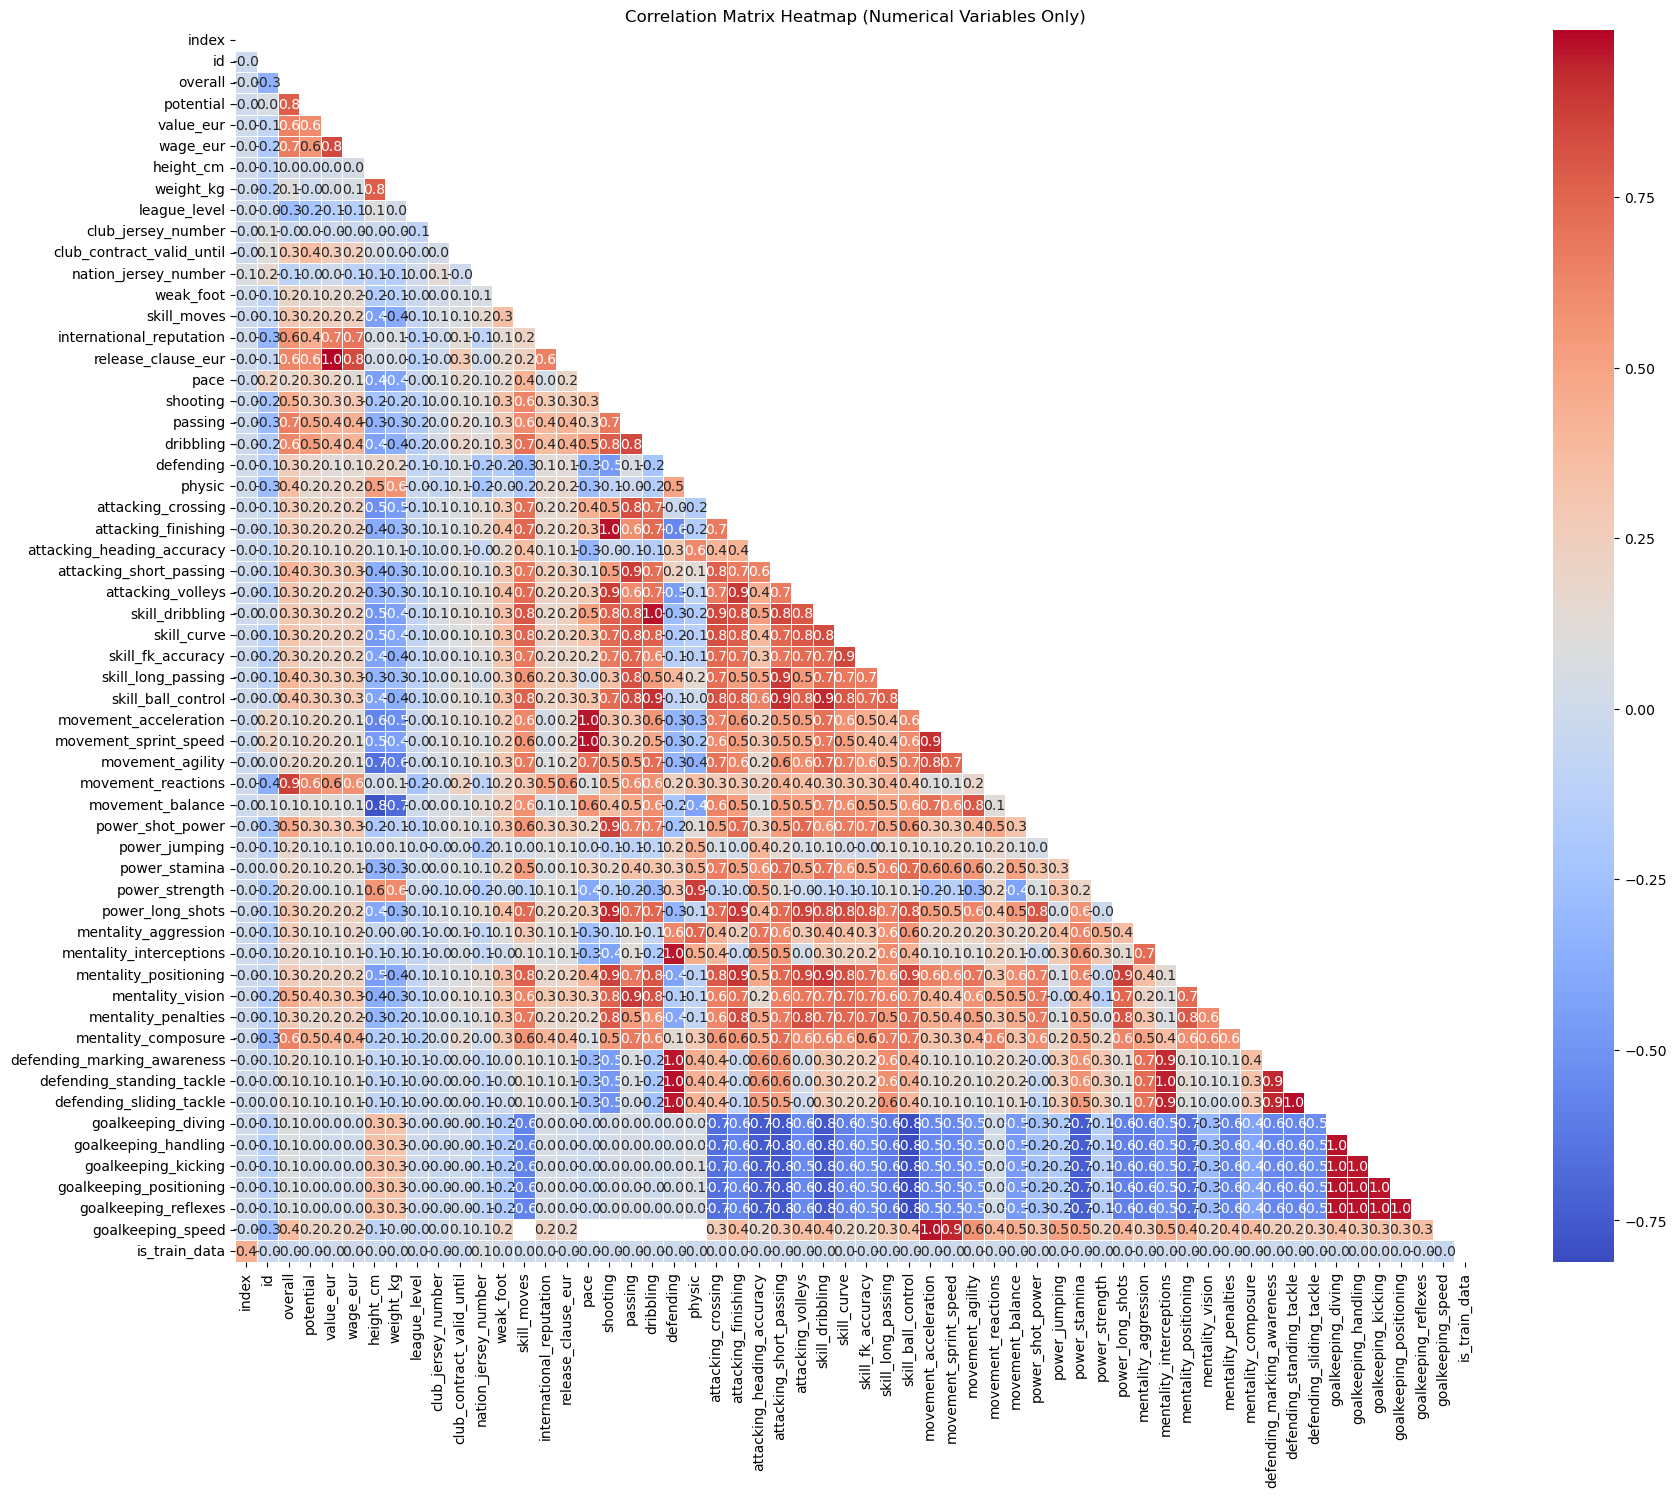

In [7]:
# Selecting numerical columns except those to be excluded
numerical_columns = [col for col in df.select_dtypes(include='number').columns]

# Creating a new dataframe with only the selected numerical columns
selected_df = df[numerical_columns]

# Correlation matrix 
correlation_matrix = selected_df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correlation_matrix)
# Create a heatmap
plt.figure(figsize=(20, 16)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5, mask=matrix)
plt.title("Correlation Matrix Heatmap (Numerical Variables Only)")
plt.show()

We see a lot of correlation between the numerical values. We will deal with them later

## Inspect categorical values

In [8]:

def calculate_column_statistics_for_categorical_variables(df):
    # Filter columns with categorical data types
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Get all column names
    all_columns = df.columns
    total_columns = len(all_columns)

    num_categorical_columns = len(categorical_columns)

    # Find columns with numeric values
    numeric_columns = [col for col in all_columns if df[col].dtype == 'int' or df[col].dtype == 'float']

    print(f"Total number of columns: {total_columns}")
    print(f"Number of categorical columns: {num_categorical_columns}")

    # Set the max_colwidth option to control the width of the displayed column
    pd.set_option('max_colwidth', 100)  # Adjust the width as needed

    # Create a dictionary to store statistics
    stats_dict = {
        'Variable': categorical_columns,
        'Number of Unique Values': [],
        'Top 5 Most Frequent Values': []
    }

    for column in categorical_columns:
        num_unique_values = df[column].nunique()
        top_5_frequent_values = df[column].value_counts().index[:5].tolist()  # Get the top 5 values as a list

        stats_dict['Number of Unique Values'].append(num_unique_values)
        stats_dict['Top 5 Most Frequent Values'].append(top_5_frequent_values)

    # Create a DataFrame from the dictionary
    stats_df = pd.DataFrame(stats_dict)

    # Sort the DataFrame downward by the number of unique values
    stats_df = stats_df.sort_values(by='Number of Unique Values', ascending=False)
    stats_df = stats_df.reset_index(drop=True)

    return stats_df

calculate_column_statistics_for_categorical_variables(df)

Total number of columns: 72
Number of categorical columns: 14


Variable  Number of Unique Values  \
0         short_name                     7418   
1      birthday_date                     4214   
2        club_joined                     1331   
3      player_traits                      825   
4          club_name                      701   
5   club_loaned_from                      207   
6   nationality_name                      144   
7        player_tags                       64   
8        league_name                       55   
9           position                       24   
10         body_type                       10   
11         work_rate                        9   
12    preferred_foot                        2   
13         real_face                        2   

                                                                             Top 5 Most Frequent Values  
0                                             [J. Rodríguez, J. Brown, M. Camara, L. Rodríguez, Danilo]  
1                                          [1992-02-29, 1996-02-29, 2000-02-29, 1988-02-29, 1991-01-08]  
2                                          [2021-07-01, 2019-07-01, 2018-07-01, 2017-07-01, 2020-07-01]  
3   [Speed Dribbler (AI), Power Header, Dives Into Tackles (AI), Long Passer (AI), Long Shot Taker (...  
4             [Vissel Kobe, Philadelphia Union, Sanfrecce Hiroshima, Seattle Sounders FC, Bengaluru FC]  
5                           [Racing Club, Manchester United, Watford, Wolverhampton Wanderers, Chelsea]  
6                                                          [England, Brazil, Germany, Spain, Argentina]  
7                                 [#Strength, #Engine, #Acrobat, #Speedster, #Aerial Threat, #Strength]  
8   [USA Major League Soccer, Argentina Primera División, English League Championship, English Leagu...  
9                                                                                [LCB, RCB, GK, RB, LB]  
10                        [Normal (170-185), Normal (185+), Lean (170-185), Lean (185+), Normal (170-)]  
11                                       [Medium/Medium, High/Medium, Medium/High, High/High, High/Low]  
12                                                                                        [Right, Left]  
13                                                                                            [No, Yes]

## take a look at missing values

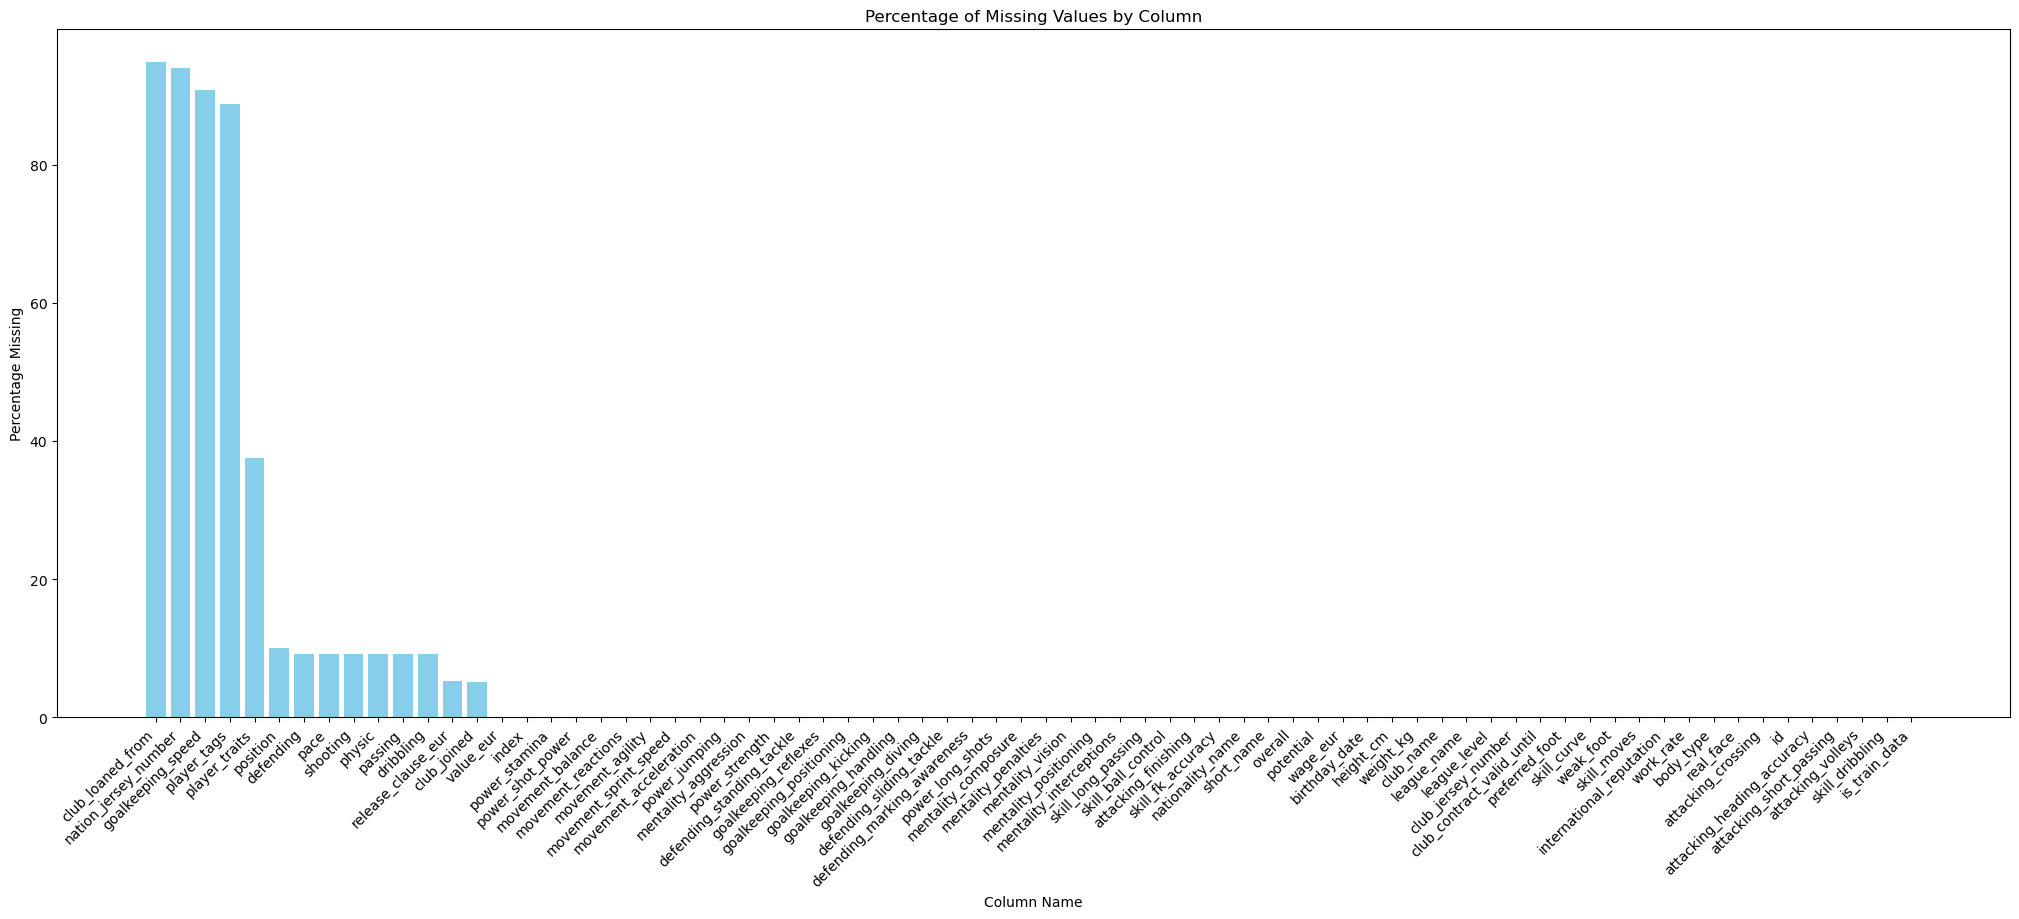


Columns with Missing Values (Descending Order):
club_loaned_from: 94.83% (Categorical)
nation_jersey_number: 93.94% (Numerical)
goalkeeping_speed: 90.85% (Numerical)
player_tags: 88.83% (Categorical)
player_traits: 37.51% (Categorical)
position: 10.01% (Categorical)
defending: 9.15% (Numerical)
pace: 9.15% (Numerical)
shooting: 9.15% (Numerical)
physic: 9.15% (Numerical)
passing: 9.15% (Numerical)
dribbling: 9.15% (Numerical)
release_clause_eur: 5.23% (Numerical)
club_joined: 5.17% (Categorical)
value_eur: 0.07% (Numerical)


In [9]:
def calculate_missing_info_print_only(df):
    # Calculate the percentage of missing values in each column
    missing_percentages_df = (df.isnull().mean() * 100).round(2).reset_index()
    missing_percentages_df.columns = ['Column Name', 'Percentage Missing']

    # Sort the DataFrame by 'Percentage Missing' in descending order
    missing_percentages_df = missing_percentages_df.sort_values(by='Percentage Missing', ascending=False)

    # Classify columns as numerical or categorical
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object', 'bool']).columns.tolist()
    missing_percentages_df['Column Type'] = missing_percentages_df['Column Name'].apply(
        lambda x: 'Numerical' if x in numerical_columns else 'Categorical'
    )

    # Display a bar chart of missing values with increased space between bars
    plt.figure(figsize=(20, 9))
    plt.bar(missing_percentages_df['Column Name'], missing_percentages_df['Percentage Missing'], color='skyblue')
    plt.xlabel('Column Name')
    plt.ylabel('Percentage Missing')
    plt.title('Percentage of Missing Values by Column')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout(pad=0.0001)  # Adjust the padding between bars
    plt.show()

    # Print column names, missing percentages, and column types for columns with missing values higher than 0%
    print("\nColumns with Missing Values (Descending Order):")
    for index, row in missing_percentages_df.iterrows():
        if row['Percentage Missing'] > 0:
            print(f"{row['Column Name']}: {row['Percentage Missing']}% ({row['Column Type']})")

# Example usage with the existing DataFrame 'df'
calculate_missing_info_print_only(df)



Dealing with missing values.

Taking a looking at missing values, club_loaned_from, nation_jersey_number, club_joined are not relevant in terms of positioning. 

Observing the numerical values, goalkeeping_speed, defending, pace, shooting, passing, dribling, physic, it does not also make sense to fill them in any way, as they are caractheristics from the players themselves and there is a nice relation between them.

If you look at goalkepping_speed, you see that it is 90.85%. The other missing values are 9.15%, meaning that probably we have here a relation that the goalkeeping_speed misses in players which are not goalkeeps and the other ones miss in the ones that are goalkeepers.

Player_tags and player_traits might be useful. And we need to think about how to treat it.

Release Clause and value err may be collinear as they indicate pretty much the same information. Although value_eur is a variable that probably needs treatment.



# Dealing with missing values

Let's take a look first on goal_keeping speed to understand what is going on there.

We need to check two things: players with GoalKeeping speed are Goalkeepers and if there any goalkeepers without goalkeeping speed.

Our results says that the previous hyphothesis is confirmed. As a result, and to reduce the number of columns, we will create a Dummy-Variable for GK

In [10]:
# Filter the DataFrame for players with non-null 'goalkeeping_speed' values for the train data
players_with_gk_speed = df[(df['goalkeeping_speed'].notnull()) & (df['is_train_data'] == 1) ]

# Extracting the positions of these players
positions_of_players_with_gk_speed = players_with_gk_speed['position'].unique()

print(positions_of_players_with_gk_speed)

# Check for goalkeepers without 'goalkeeping_speed' values
gk_without_gk_speed = df[(df['position'] == 'GK') & (df['goalkeeping_speed'].isnull())]

gk_without_gk_speed_count = gk_without_gk_speed.shape[0]
print(gk_without_gk_speed_count)



['GK']
0


In [11]:
# Create a new column 'GK_Dummy' 
df['GK_Dummy'] =  pd.notna(df['goalkeeping_speed']).astype(int)

# drop columns for goal_keeping to reduce number of columns
columns_to_drop = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']	

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

Idea: Since we already know, that all players where 'GK_Dummy' = 1, maybe exclude these rows from further data analysis and the model and just impute the predictions manually

In [12]:
df_only_goalkeepers = df[df['GK_Dummy'] == 1]
df_only_goalkeepers

index      id       short_name  overall  potential  value_eur  wage_eur  \
1      3019    1179        G. Buffon       80         80    2300000     18000   
2      3804    2147  M. Stekelenburg       76         76     825000      8000   
5      3402   19541        G. Morris       64         64      60000      2000   
9       253   24630       Pepe Reina       78         78    1600000     27000   
13     5686   49000      A. McGregor       77         77    1200000     23000   
...     ...     ...              ...      ...        ...        ...       ...   
7591    711  263023        N. Sauter       56         69     300000       500   
7594   4769  263032     V. Kovacević       68         75    2100000      2000   
7599    416  263063      J. Trafford       59         77     500000       500   
7614   1004  263232      Luiz Felipe       66         70     975000      1000   
7622    725  263339     C. Rushworth       63         80    1100000      1000   

     birthday_date  height_cm  weight_kg  ... mentality_positioning  \
1       1978-01-28        192         92  ...                    12   
2       1982-09-22        197         92  ...                    12   
5       1983-12-20        183         70  ...                    14   
9       1982-08-31        188         92  ...                    13   
13      1982-01-31        183         74  ...                    13   
...            ...        ...        ...  ...                   ...   
7591    2003-04-06        190         80  ...                     9   
7594    1998-04-11        192         81  ...                     4   
7599    2002-10-10        191         78  ...                     7   
7614    1997-04-24        198         90  ...                     4   
7622    2001-07-02        188         86  ...                     7   

     mentality_vision  mentality_penalties  mentality_composure  \
1                  50                   22                   70   
2                  40                   23                   59   
5                  41                   29                   56   
9                  65                   24                   64   
13                 61                   23                   68   
...               ...                  ...                  ...   
7591               26                   14                   30   
7594               55                   11                   56   
7599               22                   16                   26   
7614               37                   10                   26   
7622               44                   10                   42   

     defending_marking_awareness defending_standing_tackle  \
1                             13                        11   
2                              9                        15   
5                             13                        22   
9                             20                        22   
13                            15                        13   
...                          ...                       ...   
7591                           8                        13   
7594                           8                        13   
7599                           5                        13   
7614                           7                        10   
7622                           7                        14   

      defending_sliding_tackle position  is_train_data GK_Dummy  
1                           11       GK              1        1  
2                           14       GK              1        1  
5                           24       GK              1        1  
9                           24      NaN              0        1  
13                          15       GK              1        1  
...                        ...      ...            ...      ...  
7591                        12      NaN              0        1  
7594                        12       GK              1        1  
7599                        13      

In [13]:
# drop these rows from the original df (put them back together later)

df_without_gk = df[~df['id'].isin(df_only_goalkeepers['id'])]

In [14]:
df_without_gk

index      id         short_name  overall  potential  value_eur  \
0      3175      41            Iniesta       79         79    5500000   
3      5915    3467               Yuri       71         71     650000   
4      6813   18115    Rúben Fernandes       69         69     375000   
6      1725   20775           Quaresma       77         77    3400000   
7      2224   20801  Cristiano Ronaldo       91         91   45000000   
...     ...     ...                ...      ...        ...        ...   
7657   4722  264104         W. Goodwin       61         75     775000   
7658   2663  264153       D. Mondonico       59         64     300000   
7659   1490  264348          S. Rahimi       73         76    4000000   
7660   6676  264465           Luvannor       69         69    1200000   
7661   2106  264481           A. Taiwo       62         70     900000   

      wage_eur birthday_date  height_cm  weight_kg  ... mentality_positioning  \
0        10000    1984-05-11        171         68  ...                    78   
3         5000    1982-08-08        186         78  ...                    74   
4         4000    1986-05-06        187         81  ...                    40   
6        10000    1983-09-26        175         68  ...                    73   
7       270000    1985-02-05        187         83  ...                    95   
...        ...           ...        ...        ...  ...                   ...   
7657      3000    2002-05-07        193         90  ...                    61   
7658      2000    1997-05-25        193         85  ...                    30   
7659      1000    1996-06-02        181         76  ...                    73   
7660     12000    1990-05-19        182         77  ...                    71   
7661      3000    1998-08-05        185         80  ...                    60   

     mentality_vision  mentality_penalties  mentality_composure  \
0                  90                   71                   89   
3                  59                   73                   71   
4                  52                   67                   70   
6                  83                   73                   82   
7                  76                   88                   95   
...               ...                  ...                  ...   
7657               53                   58                   58   
7658               45                   37                   52   
7659               73                   67                   68   
7660               65                   62                   75   
7661               48                   60                   51   

     defending_marking_awareness defending_standing_tackle  \
0                             68                        53   
3                             41                        22   
4                             73                        69   
6                             29                        17   
7                             24                        32   
...                          ...                       ...   
7657                          22                        25   
7658                          58                        67   
7659                          35                        34   
7660                          30                        29   
7661                          15                        24   

      defending_sliding_tackle position  is_train_data GK_Dummy  
0                           50      CAM              1        0  
3                           19       LS              1        0  
4                           67      LCB              1        0  
6                           11       RW              1        0  
7                           24       ST              1        0  
...                        ...      ...            ...      ...  
7657                        25       RS              1        0  
7658                        64       CB              1        0  
7659        

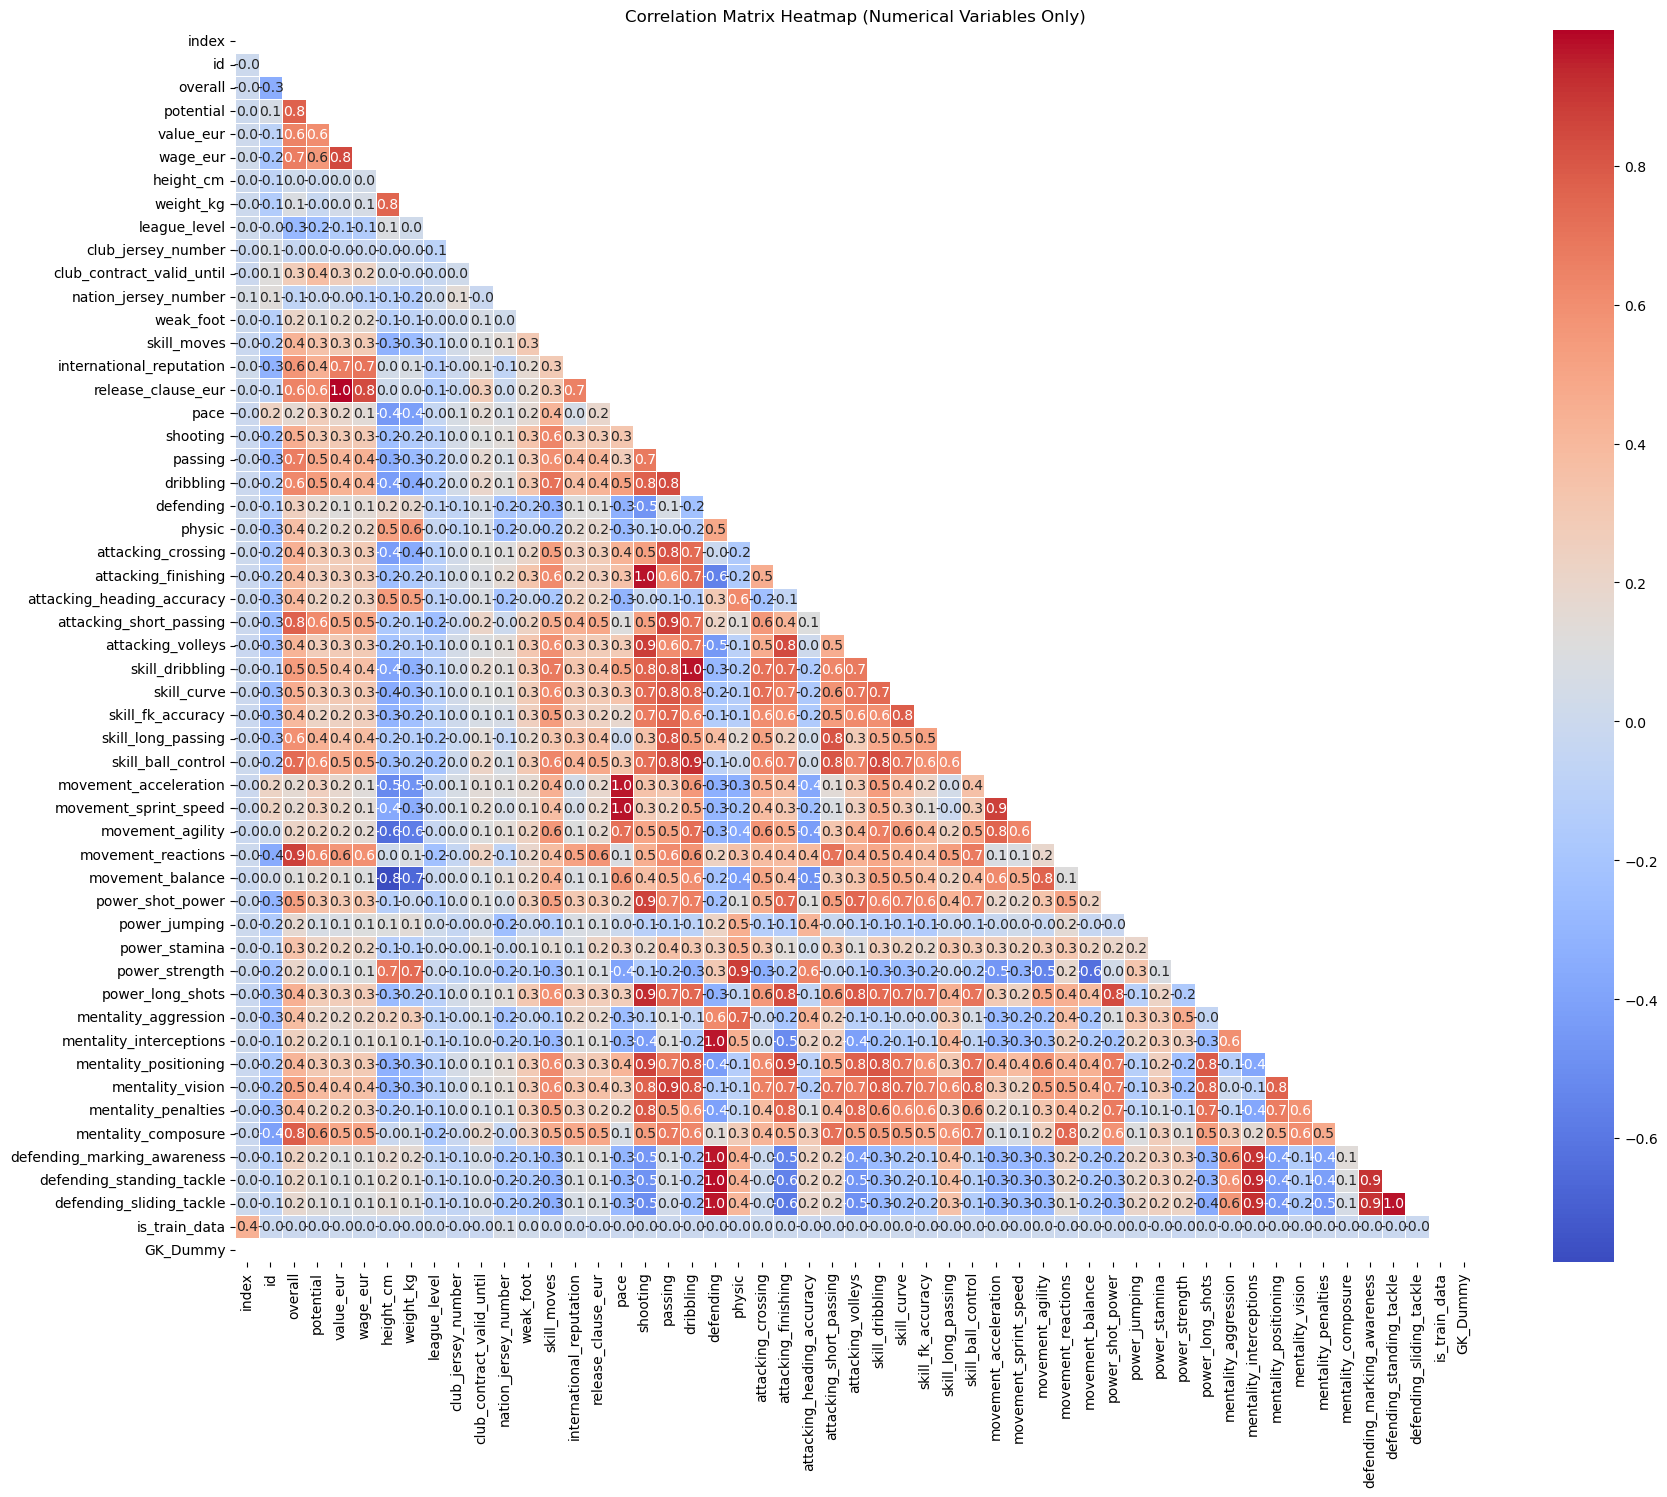

In [15]:
# Selecting numerical columns except those to be excluded
numerical_columns = [col for col in df_without_gk.select_dtypes(include='number').columns]

# Creating a new dataframe with only the selected numerical columns
selected_df = df_without_gk[numerical_columns]

# Correlation matrix 
correlation_matrix = selected_df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correlation_matrix)
# Create a heatmap
plt.figure(figsize=(20, 16)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5, mask=matrix)
plt.title("Correlation Matrix Heatmap (Numerical Variables Only)")
plt.show()

There are a lot of variables, that are perfectly correlated (dealing with them later):
- release_clause_eur and value_eur
- attacking_finishing and shooting
- skill_dribbling and dribbling
- movement_acceleration, movement_sprint_speed and pace
- mentality_interceptions, defending_making_awareness, defending_standing_tackle and defending_sliding_tackle

Also, there are a lot of variables that have a high correlation. We define a function that summarises high correlated variables.

In [16]:
def print_high_correlations(df, threshold=0.8):
    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Find correlations higher than the threshold
    high_correlations = (correlation_matrix.abs() > threshold) & (correlation_matrix < 1)

    # Keep track of printed columns to avoid redundancy
    printed_columns = set()

    # Print the results
    for column in high_correlations.columns:
        correlated_columns = high_correlations.index[high_correlations[column]].tolist()
        if len(correlated_columns) > 0:
            # Check if the column has been printed before
            if column not in printed_columns:
                # Calculate mean correlation value
                correlation_values = [correlation_matrix.loc[column, col] for col in correlated_columns]
                mean_correlation = sum(correlation_values) / len(correlation_values)
                print(f"High correlation for '{column}': {', '.join(correlated_columns)} (Mean Correlation: {mean_correlation:.2f})")
                printed_columns.add(column)
            # Mark the correlated columns as printed
            printed_columns.update(correlated_columns)

In [11]:
print_high_correlations(selected_df)

High correlation for 'overall': movement_reactions (Mean Correlation: 0.87)
High correlation for 'value_eur': wage_eur, release_clause_eur (Mean Correlation: 0.92)
High correlation for 'pace': movement_acceleration, movement_sprint_speed (Mean Correlation: 0.97)
High correlation for 'shooting': attacking_finishing, attacking_volleys, power_shot_power, power_long_shots, mentality_positioning (Mean Correlation: 0.90)
High correlation for 'passing': dribbling, attacking_crossing, attacking_short_passing, skill_curve, skill_long_passing, skill_ball_control, mentality_vision (Mean Correlation: 0.84)
High correlation for 'defending': mentality_interceptions, defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle (Mean Correlation: 0.97)
High correlation for 'physic': power_strength (Mean Correlation: 0.88)


In order to decide which of the correlated variables to keep, we use XGboost to examine the effect of tthe numericl variables on the position

In [17]:
X = df_without_gk[df_without_gk['is_train_data']==1][numerical_columns]
y = df_without_gk[df_without_gk['is_train_data']==1]['position']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

([<matplotlib.axis.YTick at 0x2816b5b50>,
 [Text(0, 0, 'GK_Dummy'),
  Text(0, 1, 'is_train_data'),
  Text(0, 2, 'weak_foot'),
  Text(0, 3, 'index'),
  Text(0, 4, 'skill_moves'),
  Text(0, 5, 'value_eur'),
  Text(0, 6, 'potential'),
  Text(0, 7, 'club_contract_valid_until'),
  Text(0, 8, 'release_clause_eur'),
  Text(0, 9, 'movement_reactions'),
  Text(0, 10, 'weight_kg'),
  Text(0, 11, 'power_shot_power'),
  Text(0, 12, 'mentality_aggression'),
  Text(0, 13, 'wage_eur'),
  Text(0, 14, 'skill_curve'),
  Text(0, 15, 'mentality_composure'),
  Text(0, 16, 'attacking_volleys'),
  Text(0, 17, 'id'),
  Text(0, 18, 'league_level'),
  Text(0, 19, 'power_jumping'),
  Text(0, 20, 'movement_balance'),
  Text(0, 21, 'passing'),
  Text(0, 22, 'power_stamina'),
  Text(0, 23, 'skill_ball_control'),
  Text(0, 24, 'height_cm'),
  Text(0, 25, 'mentality_penalties'),
  Text(0, 26, 'power_long_shots'),
  Text(0, 27, 'skill_fk_accuracy'),
  Text(0, 28, 'movement_agility'),
  Text(0, 29, 'physic'),
  Text(0,

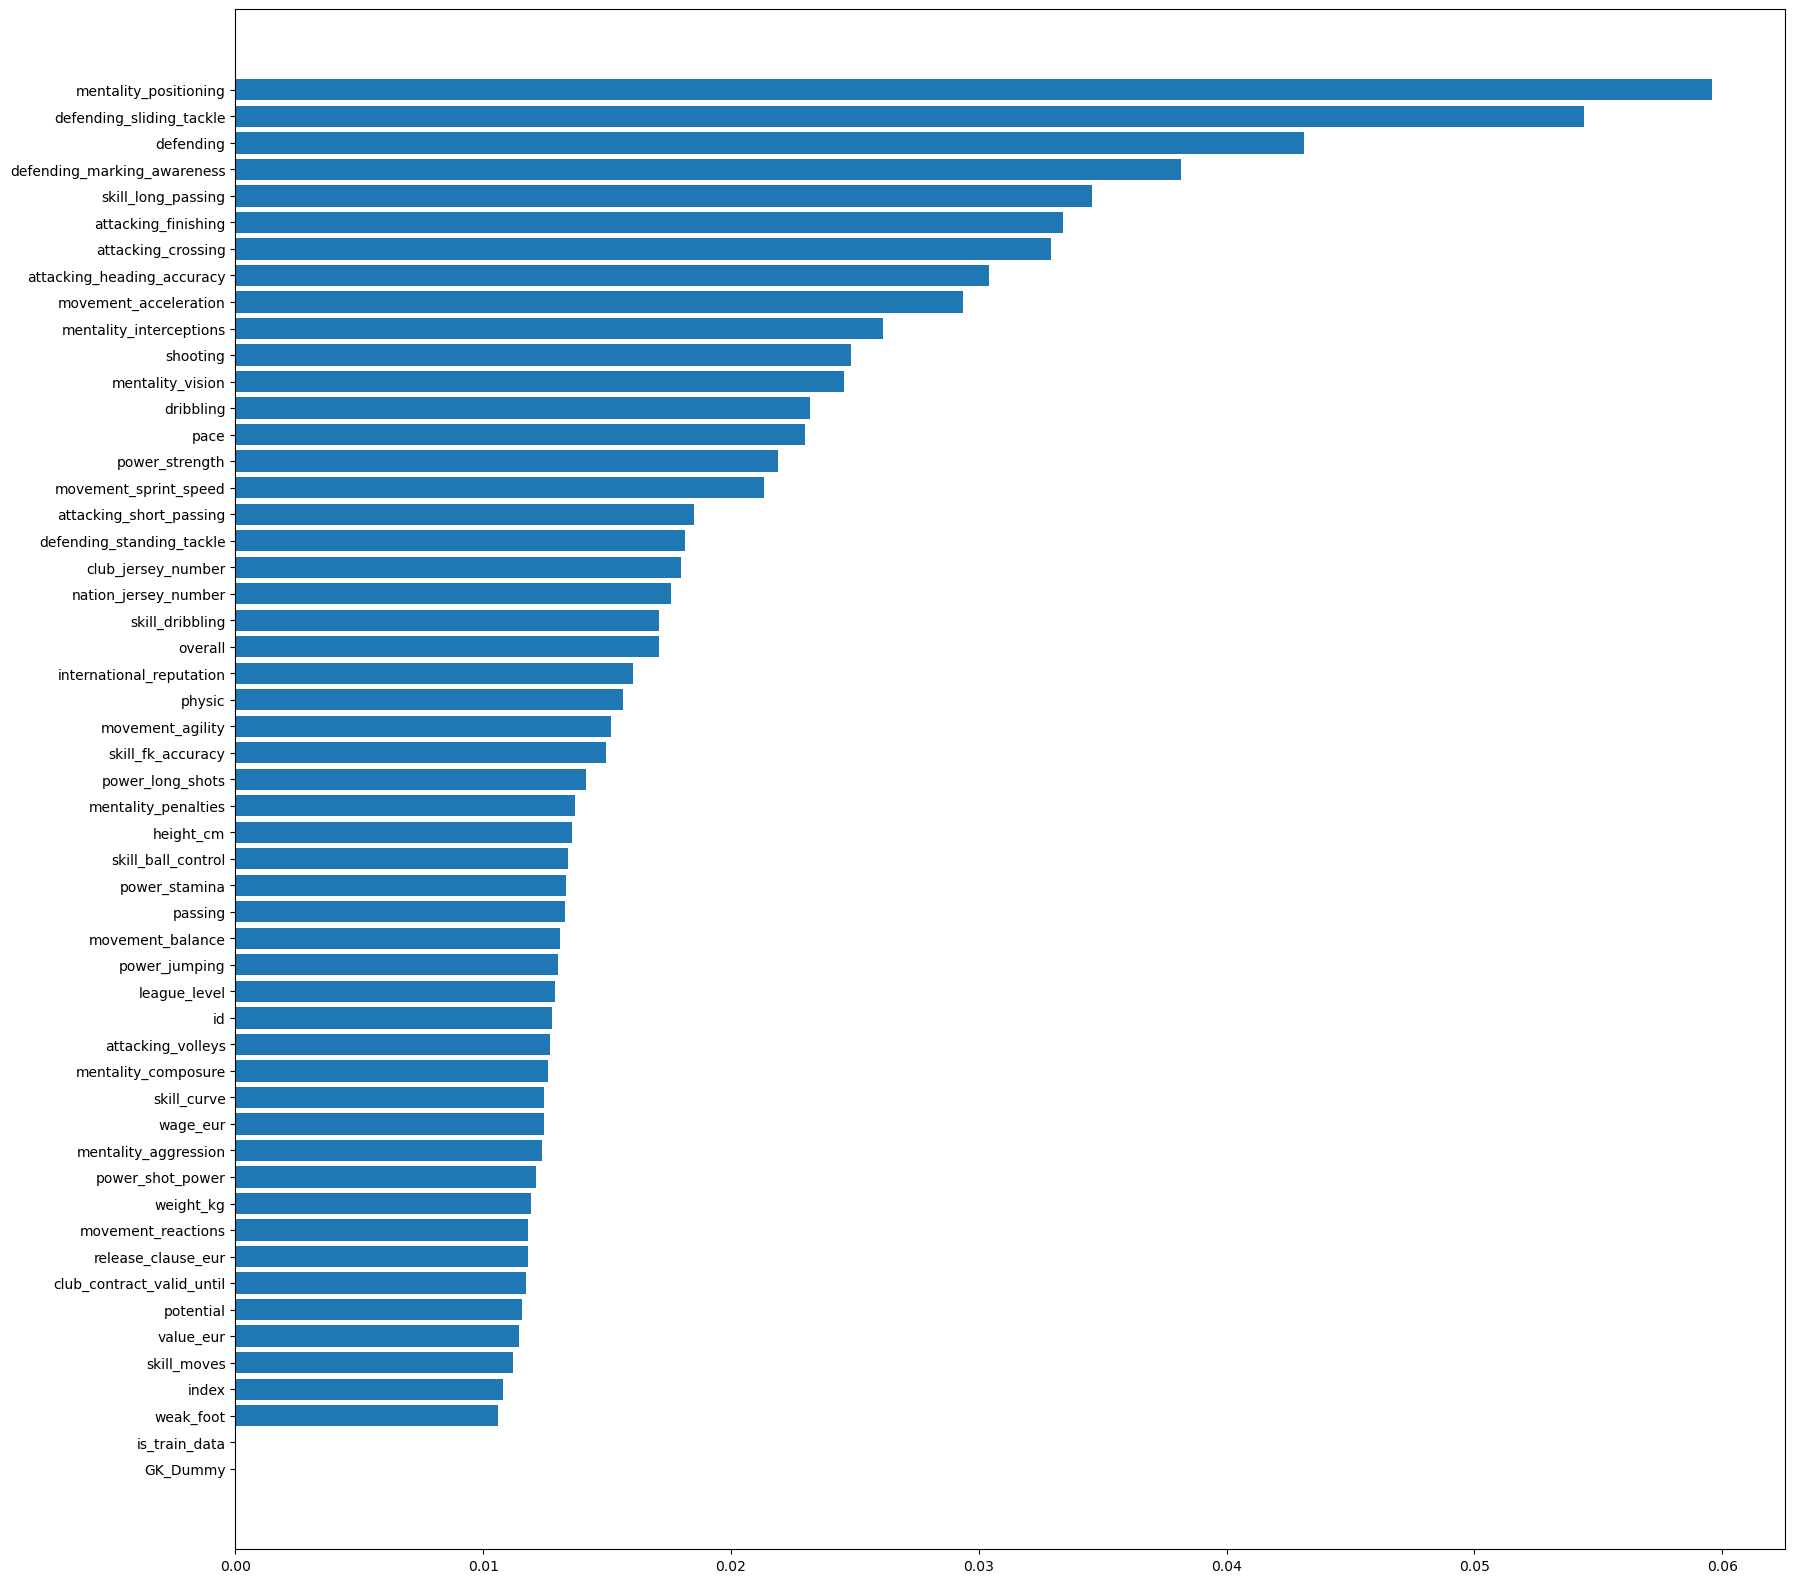

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)
sorted_indices = np.argsort(model.feature_importances_)

# Access feature names from the model
feature_names = X.columns


plt.figure(figsize=[20, 20])
plt.barh(range(len(sorted_indices)), model.feature_importances_[sorted_indices])
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])

Dealing with all correlation

High correlation for 'overall': movement_reactions (Mean Correlation: 0.87): overall has higher impact on position

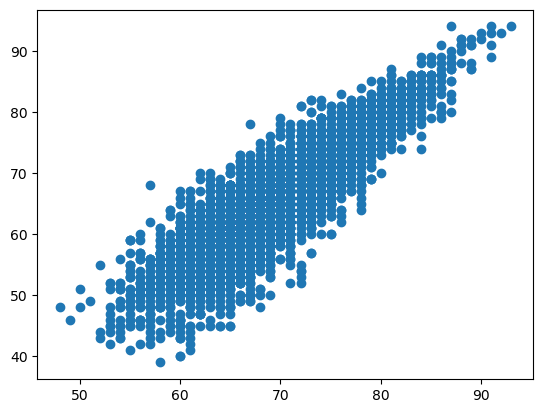

In [19]:
# look at scatterplot
plt.scatter(df_without_gk['overall'], df_without_gk['movement_reactions'])

Since they have the same scale, we can just drop movement_reactions

In [20]:
df.drop('movement_reactions', axis=1, inplace=True)

High correlation for 'pace': movement_acceleration, movement_sprint_speed (Mean Correlation: 0.97): highest impact has movement_acceleration

In [21]:
# look at values in each of the variables

df_without_gk[['pace', 'movement_acceleration', 'movement_sprint_speed']].describe()

pace  movement_acceleration  movement_sprint_speed
count  6961                   6961                   6961
mean   68.6                   68.5                   68.6
std    11.7                   12.2                   12.0
min      28                     29                     28
25%      62                     62                     63
50%      70                     70                     70
75%      77                     77                     77
max      97                     97                     97

Since all have nearly the same values, we just drop pace and movement_sprint_speed

In [22]:
columns_to_drop = ['pace', 'movement_sprint_speed']	

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

High correlation for 'shooting': attacking_finishing, attacking_volleys, power_shot_power, power_long_shots, mentality_positioning (Mean Correlation: 0.90): highest impact has mentality positioning

In [23]:
# look at values in each of the variables

df_without_gk[['shooting', 'attacking_finishing', 'attacking_volleys', 'power_shot_power', 'power_long_shots', 'mentality_positioning']].describe()

shooting  attacking_finishing  attacking_volleys  power_shot_power  \
count      6961                 6961               6961              6961   
mean       54.3                 51.8               48.0              61.6   
std        14.4                 16.6               15.4              13.1   
min          18                   10                 10                20   
25%          43                   38                 35                54   
50%          57                   55                 49                64   
75%          65                   65                 59                71   
max          94                   95                 90                94   

       power_long_shots  mentality_positioning  
count              6961                   6961  
mean               53.6                   57.3  
std                16.0                   14.7  
min                  11                     12  
25%                  42                     49  
50%                  57                     60  
75%                  66                     68  
max                  94                     96

Since the means are quite different, we introduce a knew variable, that is the mean of all these variables and drop them afterwards

In [24]:
df_without_gk['shooting_attacking_power']= df_without_gk[['shooting', 'attacking_finishing', 'attacking_volleys', 'power_shot_power', 'power_long_shots', 'mentality_positioning']].mean(axis=1)

columns_to_drop = ['shooting', 'attacking_finishing', 'attacking_volleys', 'power_shot_power', 'power_long_shots', 'mentality_positioning']	

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

High correlation for 'passing': dribbling, attacking_crossing, attacking_short_passing, skill_curve, skill_long_passing, skill_ball_control, mentality_vision (Mean Correlation: 0.84): highest impact has skill_longpassing

In [25]:
df_without_gk[['passing', 'dribbling', 'attacking_crossing', 'attacking_short_passing', 'skill_curve', 'skill_long_passing', 'skill_ball_control', 'mentality_vision']].describe()

passing  dribbling  attacking_crossing  attacking_short_passing  \
count     6961       6961                6961                     6961   
mean      60.1       64.6                56.7                     65.7   
std        9.6        9.3                13.7                      8.2   
min         25         29                  15                       24   
25%         54         59                  48                       61   
50%         60         65                  59                       66   
75%         67         71                  66                       71   
max         93         95                  94                       94   

       skill_curve  skill_long_passing  skill_ball_control  mentality_vision  
count         6961                6961                6961              6961  
mean          53.9                59.7                65.9              58.3  
std           15.3                11.0                 8.7              12.8  
min             13                  20                  27                17  
25%             42                  53                  61                50  
50%             55                  61                  66                60  
75%             65                  67                  72                67  
max             94                  93                  96                95

Since the means are quite different, we introduce a knew variable, that is the mean of all these variables and drop them afterwards

In [26]:
df_without_gk['attacking_skill']= df_without_gk[['passing', 'dribbling', 'attacking_crossing', 'attacking_short_passing', 'skill_curve', 'skill_long_passing', 'skill_ball_control', 'mentality_vision']].mean(axis=1)

columns_to_drop = ['passing', 'dribbling', 'attacking_crossing', 'attacking_short_passing', 'skill_curve', 'skill_long_passing', 'skill_ball_control', 'mentality_vision']

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

High correlation for 'defending': mentality_interceptions, defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle (Mean Correlation: 0.97): highest impact has defedning_sliding_tackle

In [27]:
# look at values in each of the variables

df_without_gk[['defending','mentality_interceptions', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']].describe()

defending  mentality_interceptions  defending_marking_awareness  \
count       6961                     6961                         6961   
mean        55.6                     54.9                         54.9   
std         15.6                     17.7                         16.8   
min           16                       10                           10   
25%           43                       42                           42   
50%           61                       61                           60   
75%           67                       68                           67   
max           91                       91                           92   

       defending_standing_tackle  defending_sliding_tackle  
count                       6961                      6961  
mean                        56.1                      53.4  
std                         17.9                      18.1  
min                           10                        10  
25%                           43                        39  
50%                           63                        60  
75%                           69                        66  
max                           93                        92

Since all have nearly the same values, we just drop all columns except defending_sliding_tackle

In [28]:
columns_to_drop = ['defending','mentality_interceptions', 'defending_marking_awareness', 'defending_standing_tackle']

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

High correlation for 'physic': power_strength (Mean Correlation: 0.88): highest impact has power_strength

In [29]:
# look at values in each of the variables

df_without_gk[['physic','power_strength']].describe()

physic  power_strength
count    6961            6961
mean     68.3            68.8
std       8.5            11.7
min        31              25
25%        63              62
50%        69              70
75%        74              77
max        90              95

Since all have nearly the same values, we just drop physic

In [30]:
columns_to_drop = ['physic']

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

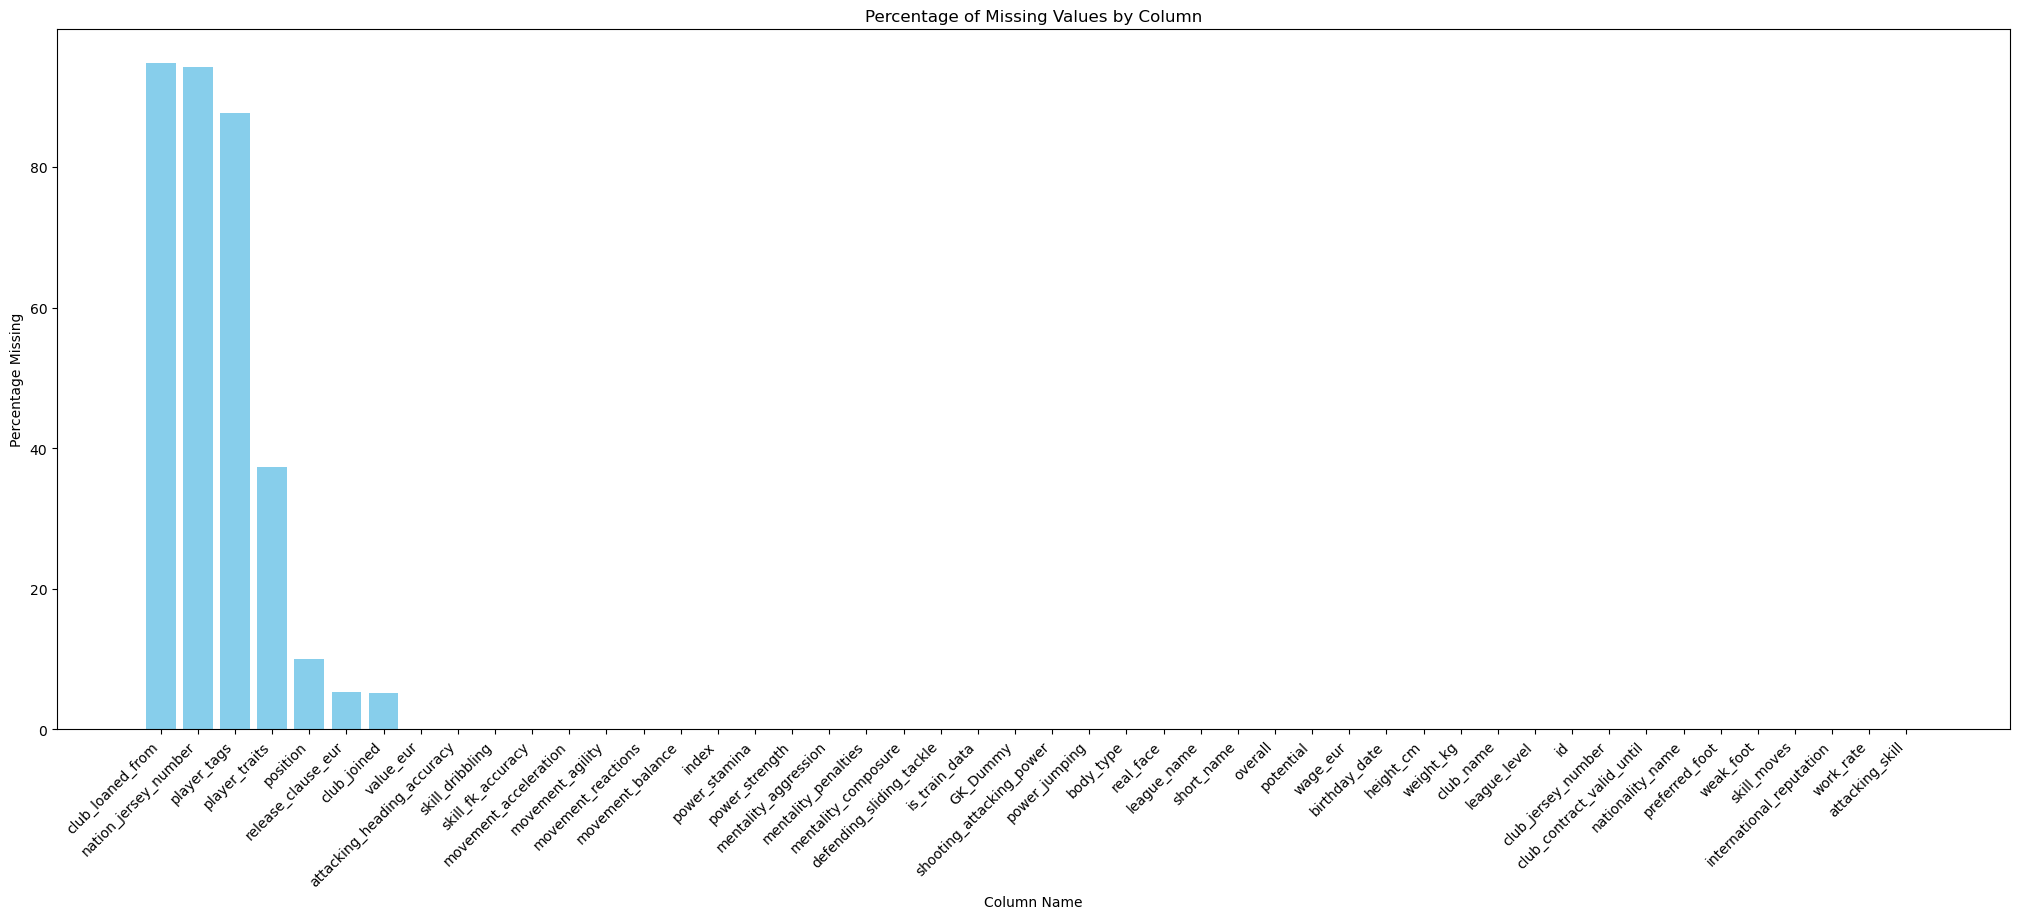


Columns with Missing Values (Descending Order):
club_loaned_from: 94.83% (Categorical)
nation_jersey_number: 94.27% (Numerical)
player_tags: 87.7% (Categorical)
player_traits: 37.37% (Categorical)
position: 10.01% (Categorical)
release_clause_eur: 5.24% (Numerical)
club_joined: 5.17% (Categorical)
value_eur: 0.07% (Numerical)


In [31]:
calculate_missing_info_print_only(df_without_gk)


Now I wil drop club_loaned_from, nation_jersey_number and club_joined

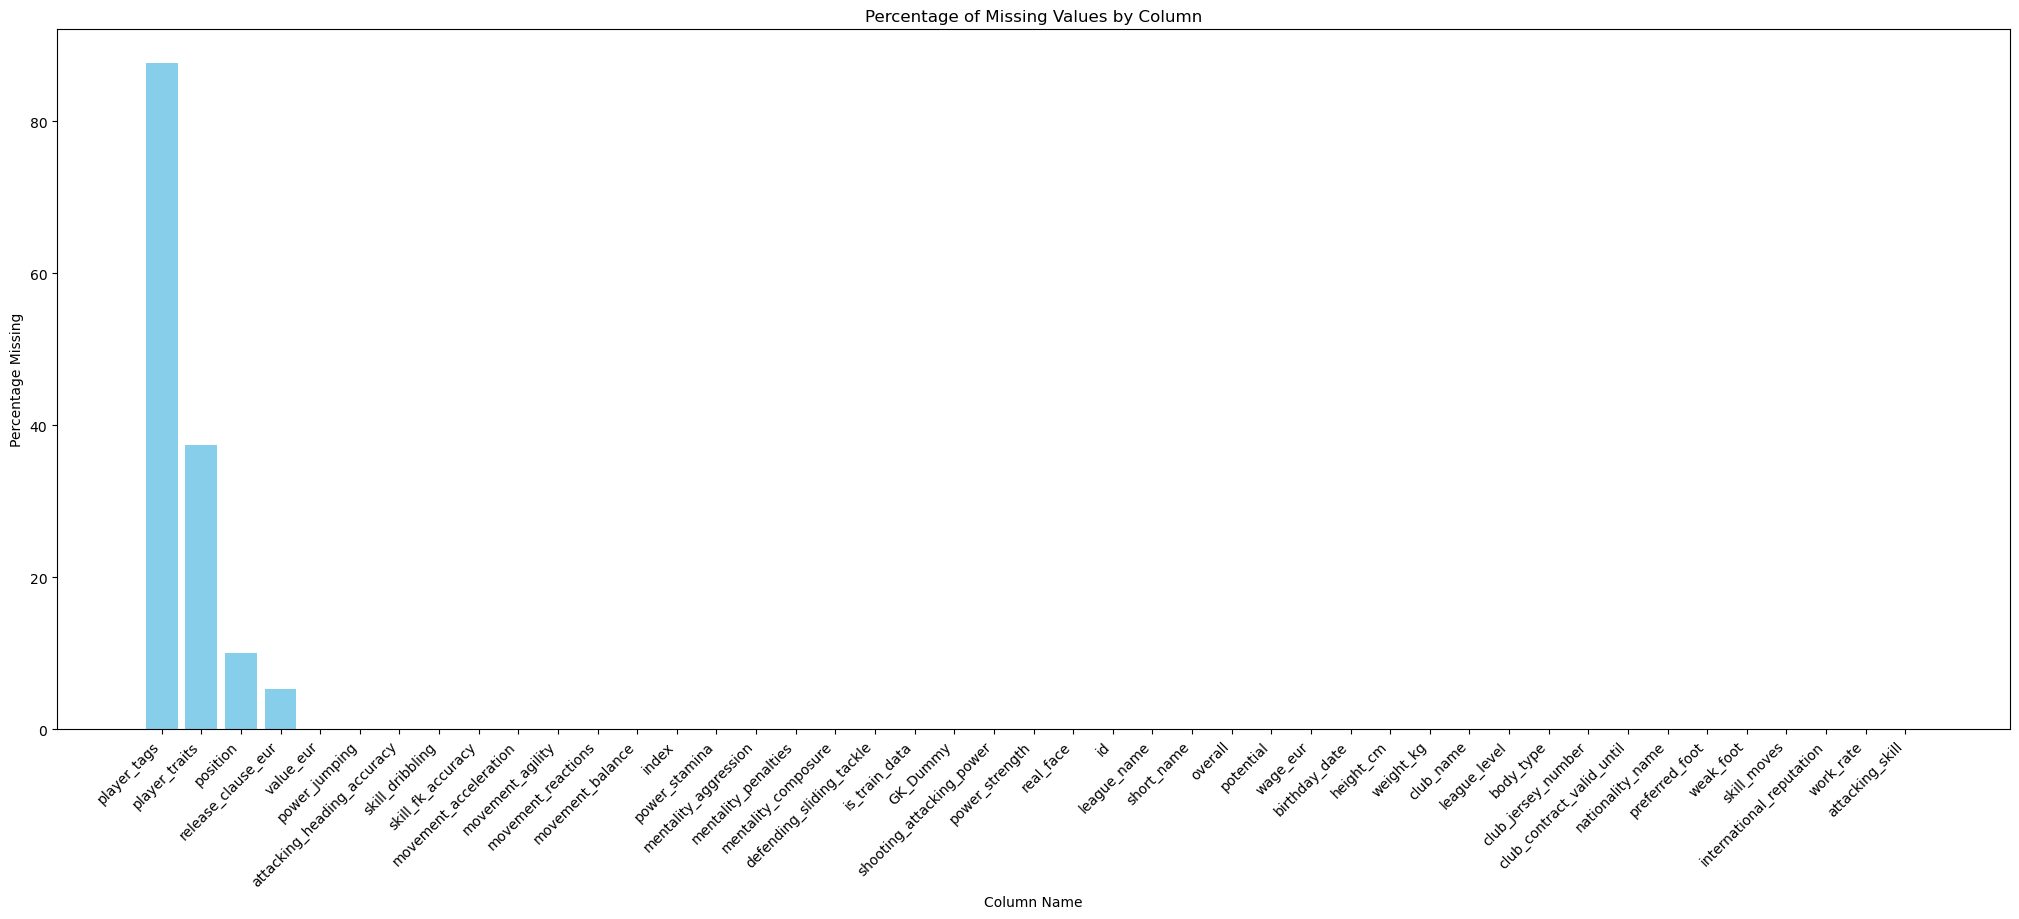


Columns with Missing Values (Descending Order):
player_tags: 87.7% (Categorical)
player_traits: 37.37% (Categorical)
position: 10.01% (Categorical)
release_clause_eur: 5.24% (Numerical)
value_eur: 0.07% (Numerical)


In [32]:
def drop_columns(df):
    return df.drop(['club_loaned_from', 'nation_jersey_number', 'club_joined'], axis=1)

df_without_gk=drop_columns(df_without_gk)

calculate_missing_info_print_only(df_without_gk)


Taking care of value_eur and release_clause_eur.

Release_clause_eur is correlated almost as 1 with value_eur. 
We just have 5 observations without value and they dont have release_clause_eur.





In [33]:
corr_release_value = df_without_gk[['release_clause_eur', 'value_eur']].corr()
corr_release_value

release_clause_eur  value_eur
release_clause_eur                   1        1.0
value_eur                          1.0          1

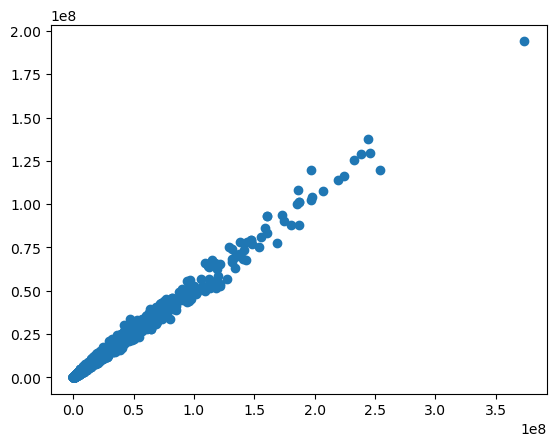

In [34]:
plt.scatter(df_without_gk['release_clause_eur'], df_without_gk['value_eur'])

In [35]:
print(df_without_gk['release_clause_eur'].mean())
print(df_without_gk['value_eur'].mean())

8240939.660400243
4373757.906843013


From the scatterplot and from the means you can see that both variables have nearly a 1 to 2 relationship. That is how we impute the missing values in value_eur

In [36]:
df_without_gk[(df_without_gk['value_eur'].isna()) & (df_without_gk['release_clause_eur'].isna())]

index      id    short_name  overall  potential  value_eur  wage_eur  \
26      10  115909  Rubén Castro       69         69        NaN      3000   
30    4001  124344     İ. Öztürk       67         67        NaN      3000   
44     633  140222   P. Da Silva       67         67        NaN       500   
79    5599  152912       J. Sand       75         75        NaN     13000   
115    147  158293     Zheng Zhi       67         67        NaN      5000   

    birthday_date  height_cm  weight_kg  ... power_strength  \
26     1981-06-27        169         68  ...             61   
30     1981-06-21        186         80  ...             78   
44     1980-02-01        180         76  ...             83   
79     1980-07-17        182         79  ...             83   
115    1980-08-20        180         75  ...             63   

    mentality_aggression  mentality_penalties  mentality_composure  \
26                    54                   75                   68   
30                    78                   51                   51   
44                    70                   43                   70   
79                    73                   85                   85   
115                   87                   68                   72   

     defending_sliding_tackle position is_train_data  GK_Dummy  \
26                         14      NaN             0         0   
30                         62       CB             1         0   
44                         64      NaN             0         0   
79                         25       LS             1         0   
115                        62      NaN             0         0   

     shooting_attacking_power  attacking_skill  
26                       70.2             63.6  
30                       45.2             47.5  
44                       34.7             44.8  
79                       78.3             63.1  
115                      64.2               67  

[5 rows x 45 columns]

SInce all rows with missing values in 'value_eur' also have missing values in 'release_clause_eur' it is not possible.

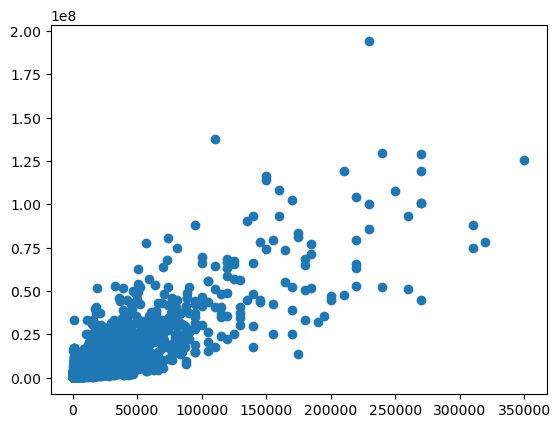

wage_eur  value_eur
wage_eur          1        0.8
value_eur       0.8          1

In [37]:
plt.scatter(df_without_gk['wage_eur'], df_without_gk['value_eur'])
plt.show()

corr_wage = df_without_gk[['wage_eur', 'value_eur']].corr()
corr_wage

Also quite high correlation between those two

In [38]:
df_without_gk['wage_eur'].isna().sum()

0

We don't have missing values in 'wage_eur' and a stron correlation to 'value_eur' (0.8) and 'release_clause_eur' (0.8). As a result, instead of dealing with missing values in 'value_eur' and/or 'release_clause_eur' we drop these columns

In [39]:
columns_to_drop = ['value_eur', 'release_clause_eur']	

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

For the moment, I will put the KNN the value_eur and drop release_clause_eur.

In [107]:
# def fill_value_eur_with_knn_and_print_details_v2(df, target_column='value_eur', n_neighbors=5):
#     categorical_columns = ['club_name', 'league_name', 'preferred_foot']

#     # Selecting numeric columns for KNN imputation
#     numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
#     df_numeric = df[numeric_columns]

#     # Creating a temporary DataFrame with encoded categorical variables
#     df_temp = df.copy()
#     for col in categorical_columns:
#         if col in df_temp.columns:
#             encoder = OrdinalEncoder()
#             df_temp[col] = encoder.fit_transform(df_temp[[col]])

#     # Merging numeric and encoded categorical data for imputation
#     df_temp = pd.concat([df_numeric, df_temp[categorical_columns]], axis=1)

#     # KNN imputer
#     imputer = KNNImputer(n_neighbors=n_neighbors)
#     df_imputed = imputer.fit_transform(df_temp)
#     df_imputed = pd.DataFrame(df_imputed, columns=df_temp.columns)

#     # Identify the indices where 'value_eur' was originally missing
#     missing_value_indices = df[df[target_column].isnull()].index

#     # Update the target column in the original DataFrame with imputed values
#     df[target_column] = df_imputed[target_column]

#     # Print the detailed imputed values and the club's median values
#     for index in missing_value_indices:
#         player_name = df.at[index, 'short_name']
#         club_name = df.at[index, 'club_name']
#         imputed_value = df_imputed.at[index, target_column]
#         club_median_value = df.groupby('club_name')[target_column].median().loc[club_name]
#         print(f"{player_name} has been filled with {imputed_value}. He plays for {club_name}, where the median wage is {club_median_value}.")

#     return df

# # Applying the function to the DataFrame
# df_filled_with_details_v2 = fill_value_eur_with_knn_and_print_details_v2(df)


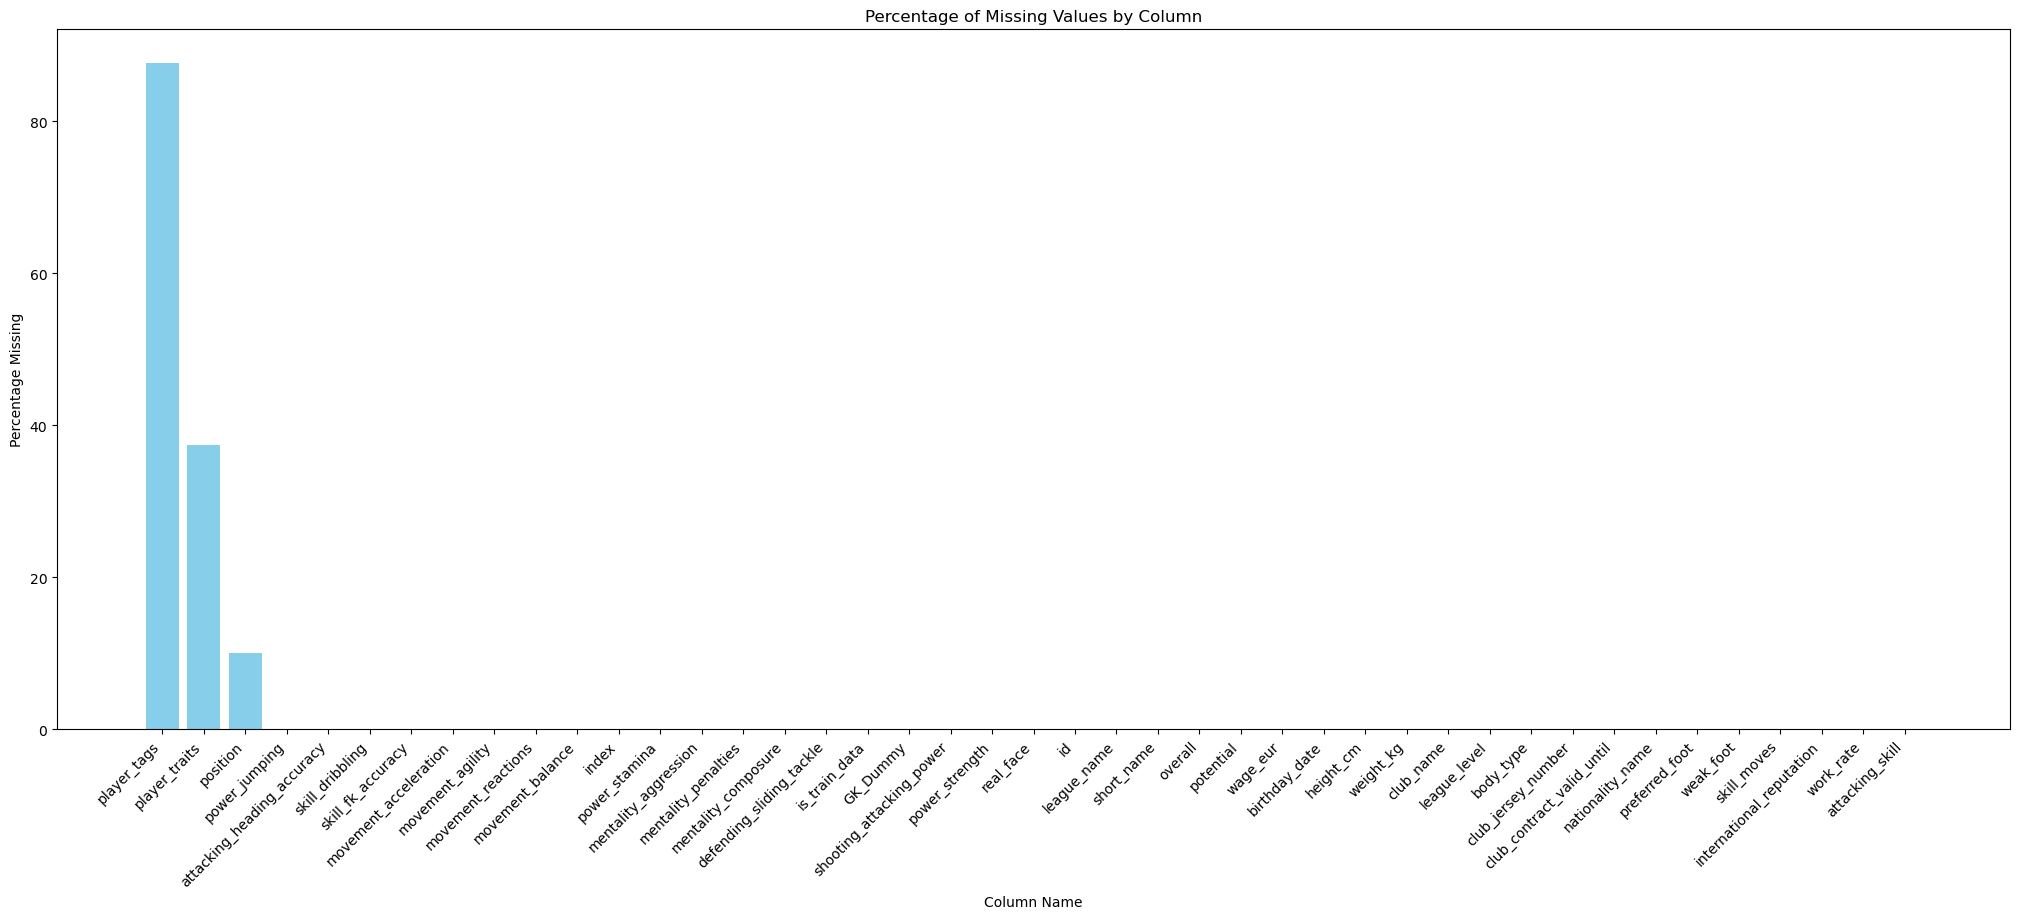


Columns with Missing Values (Descending Order):
player_tags: 87.7% (Categorical)
player_traits: 37.37% (Categorical)
position: 10.01% (Categorical)


In [40]:
# def drop_column_release_clause(df):
#     return df.drop(['release_clause_eur'], axis=1)

# df=drop_column_release_clause(df)

calculate_missing_info_print_only(df_without_gk)


I will deal with these later.

looking again at correlation to see whether all variables now are relevant

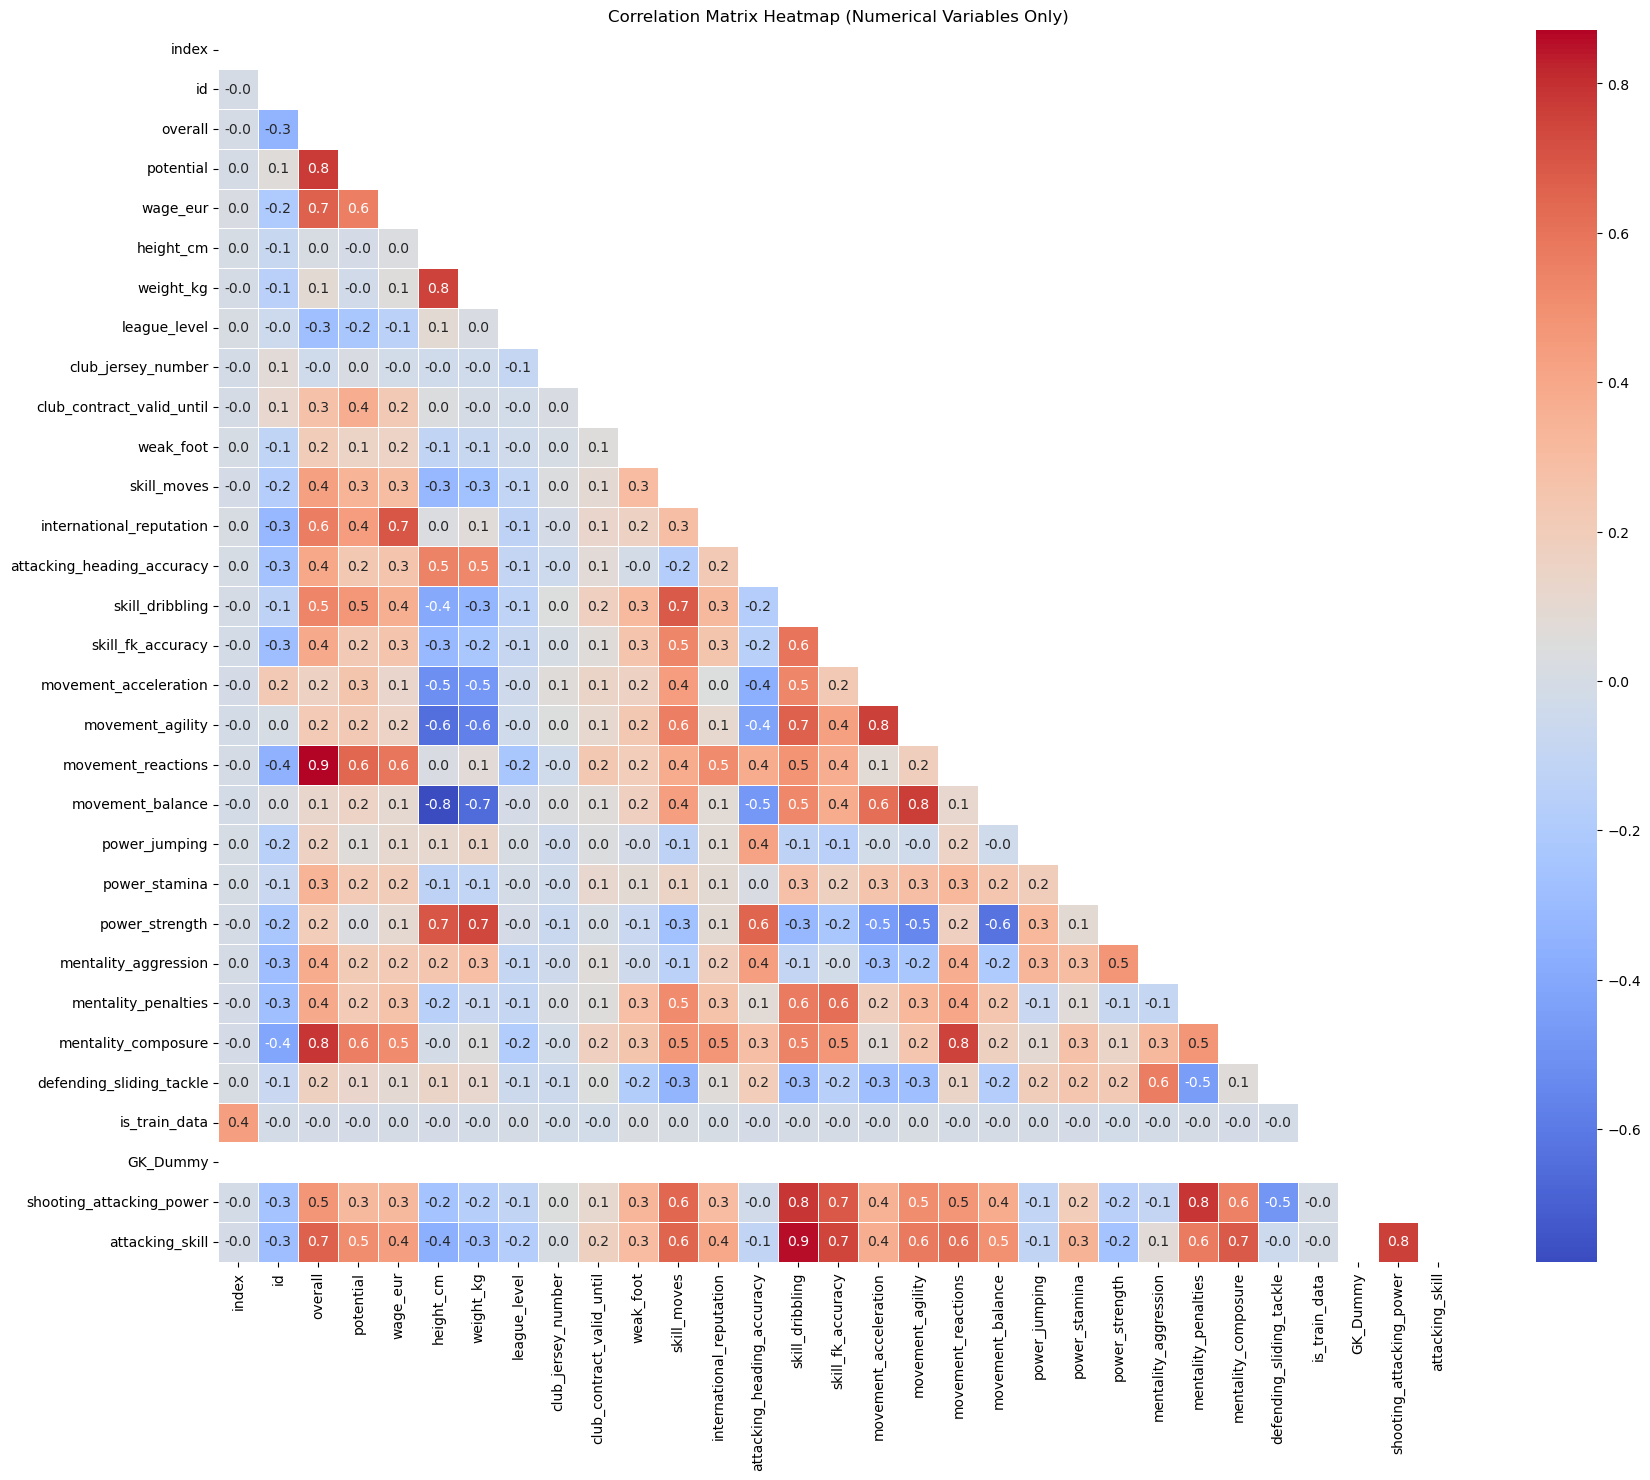

In [41]:
# Selecting numerical columns except those to be excluded
numerical_columns = [col for col in df_without_gk.select_dtypes(include='number').columns]

# Creating a new dataframe with only the selected numerical columns
selected_df = df_without_gk[numerical_columns]

# Correlation matrix 
correlation_matrix = selected_df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correlation_matrix)
# Create a heatmap
plt.figure(figsize=(20, 16)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5, mask=matrix)
plt.title("Correlation Matrix Heatmap (Numerical Variables Only)")
plt.show()

there are still some high correltions:
- overall, mentality_composure, movement_reactions, potential
- weight, height
- movement_agility, movement_acceleration
- movement_balance, movement_agility
- attacking_skill, skill_dribbling

overall, mentality_composure, movement_reactions, potential: highest impact has overall

In [42]:
# look at values in each of the variables

df_without_gk[['overall','mentality_composure', 'movement_reactions', 'potential']].describe()

overall  mentality_composure  movement_reactions  potential
count     6961                 6961                6961       6961
mean      68.8                 63.5                65.1       72.0
std        5.9                  9.3                 7.9        6.1
min         48                   33                  39         53
25%         65                   57                  60         68
50%         68                   64                  65         72
75%         72                   70                  70         76
max         93                   96                  94         95

Since the means are quite different, we introduce a knew variable, that is the mean of all these variables and drop them afterwards

In [43]:
df_without_gk['overall_potential']= df_without_gk[['overall', 'mentality_composure', 'movement_reactions', 'potential']].mean(axis=1)

columns_to_drop = ['overall', 'mentality_composure', 'movement_reactions', 'potential']

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

weight and height have a correlation, that can be shown in a scatterplot

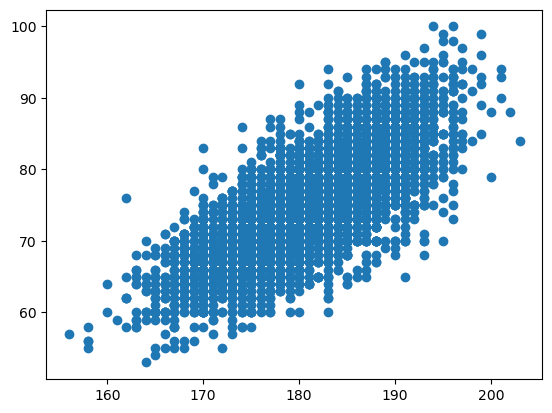

In [44]:
plt.scatter(df_without_gk['height_cm'], df_without_gk['weight_kg'])
plt.show()

to eliminate the collinearity a new variable will be introduced: weight per height

In [45]:
df_without_gk['weight_per_height']= df_without_gk['weight_kg'] / df_without_gk['height_cm']

columns_to_drop = ['weight_kg','height_cm']	

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

movement_agility, movement_acceleration and movement_balance, movement_agility have high correlation. We look at them together

In [46]:
# look at values in each of the variables

df_without_gk[['movement_agility','movement_acceleration', 'movement_balance', 'movement_agility']].describe()

movement_agility  movement_acceleration  movement_balance  \
count              6961                   6961              6961   
mean               67.7                   68.5              67.0   
std                12.5                   12.2              12.7   
min                  28                     29                26   
25%                  61                     62                60   
50%                  69                     70                68   
75%                  76                     77                76   
max                  96                     97                95   

       movement_agility  
count              6961  
mean               67.7  
std                12.5  
min                  28  
25%                  61  
50%                  69  
75%                  76  
max                  96

Since all have nearly the same values, we just drop all columns except movement_acceleration (higest impact)

In [47]:
columns_to_drop = ['movement_agility', 'movement_balance', 'movement_agility']

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

attacking_skill, skill_dribbling_ highest impact hass skill_dribbling

In [48]:
# look at values in each of the variables

df_without_gk[['attacking_skill','skill_dribbling']].describe()

attacking_skill  skill_dribbling
count             6961             6961
mean              60.6             62.8
std                9.6             11.8
min               25.8               20
25%               54.4               57
50%               61.1               64
75%               67.1               71
max               92.1               96

Since both are quite similar we drop attacking_skill

In [49]:
columns_to_drop = ['attacking_skill']

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

In [50]:
numerical_columns = [col for col in df_without_gk.select_dtypes(include='number').columns]
pd.set_option('display.max_columns', None)
df_without_gk.groupby('position')[numerical_columns].agg(['mean', 'min', 'max'])



index                  id                 wage_eur               \
           mean  min   max     mean     min     max     mean  min     max   
position                                                                    
CAM      3229.3   35  6857 221775.7      41  263030  14906.7  500  250000   
CB       3233.2   41  6799 215393.5   50632  264153   8974.9  500  145000   
CDM        3421   21  6810 223155.3  152567  263839  16554.6  500  310000   
CM       3440.3  340  6764 214890.0  151508  262925  10849.3  500   88000   
LB       3516.1    0  6876 226582.3  143025  263432  11254.4  500  200000   
LCB      3405.1   13  6893 222494.9   18115  263952  10509.9  500  185000   
LCM      3423.3    7  6891 224611.1  134820  263270  12364.4  500  310000   
LDM      3453.0    1  6850 223109.3  162329  263452  13528.1  500  140000   
LF       3246.5  156  6755 234206.8  188616  263158  11673.4  500   63000   
LM       3495.8   55  6851 229276.4  155885  264348  11143.8  500  150000   
LS       3343.0    3  6863 220362.3    3467  263493  12570.4  500  220000   
LW       3475.2   12  6858 227310.9  111590  262985  18804.5  500  270000   
LWB      3529.6    2  6892 225661.9  167919  263035   6845.7  500   58000   
RB       3404.6   14  6889 228662.7  146536  263703  11005.0  500  210000   
RCB      3524.4   20  6890 223259.4   23823  264069  10601.5  500  180000   
RCM      3486.9    9  6894 225761.8  138699  263583  12095.9  500  350000   
RDM      3497.5   32  6855 223294.6  155671  263944  11545.8  500  160000   
RF       3300.8  332  6594 220679.7  176635  262674  14410.9  500   83000   
RM       3388.5    8  6875 228596.4   45186  264465  10898.5  500  110000   
RS       3458.7   47  6880 222565.6   25798  264104  11920.9  500  135000   
RW       3551.0    5  6865 228334.0   20775  263955  17726.5  500  320000   
RWB      3545.7  120  6835 231157.3  166841  263233   9151.0  500  125000   
ST       3497.4   42  6884 219775.2   20801  264481  16309.7  500  270000   

         league_level         club_jersey_number          \
                 mean min max               mean min max   
position                                                   
CAM               1.3   1   4               15.9   4  94   
CB                1.5   1   5               14.2   2  94   
CDM               1.3   1   4               16.0   3  77   
CM                1.5   1   5               14.5   2  78   
LB                1.3   1   4               17.5   2  98   
LCB               1.4   1   5               14.8   2  99   
LCM               1.4   1   5               17.4   2  99   
LDM               1.3   1   4               16.4   2  93   
LF                1.2   1   3               22.6   7  82   
LM                1.3   1   4               18.7   2  99   
LS                1.4   1   4               15.3   7  70   
LW                1.4   1   4               19.2   2  99   
LWB               1.6   1   5               15.8   2  94   
RB                1.3   1   4               17.0   2  98   
RCB               1.4   1   5               14.5   2  97   
RCM               1.4   1   5               17.0   2  91   
RDM               1.3   1   4               15.3   3  88   
RF                1.4   1   3               18.4   7  50   
RM                1.3   1   4               17.7   2  99   
RS                1.3   1   4               16.7   7  99   
RW                1.4   1   4               17.5   5  98   
RWB               1.6   1   5               16.5   2  77   
ST                1.3   1   4               19.0   3  99   

         club_contract_valid_until             weak_foot         skill_moves  \
                              mean   min   max      mean min max        mean   
position                                                                       
CAM                         2022.9  2021  2026       3.4   2   5         3.2   
CB                          2022.6  2021  2026       2.8   2   5         2.0   
CDM                         2022.9  2021  2027

Idea: Maybe it is possible to set some positions by default (like goalkeeper). Inspect this with function

In [51]:
# Calculate the aggregated statistics (mean, min, max) for each position
agg_stats = df_without_gk.groupby('position')[numerical_columns].agg(['mean', 'min', 'max'])

# Iterate over numerical columns and check for the condition
for col in numerical_columns:
    min_values = agg_stats[col]['min']
    max_values = agg_stats[col]['max']

    # Check if the minimum value for the current position is greater than the maximum for other positions
    for position in agg_stats.index:
        other_positions = agg_stats.index.difference([position])
        if (min_values[position] > max_values[other_positions]).any():
            print(f"Condition met for '{col}' and position '{position}'")
        elif (max_values[position] < min_values[other_positions]).any():
            print(f"Condition met for '{col}' and position '{position}'")

No print messages means that the conditions are never met.

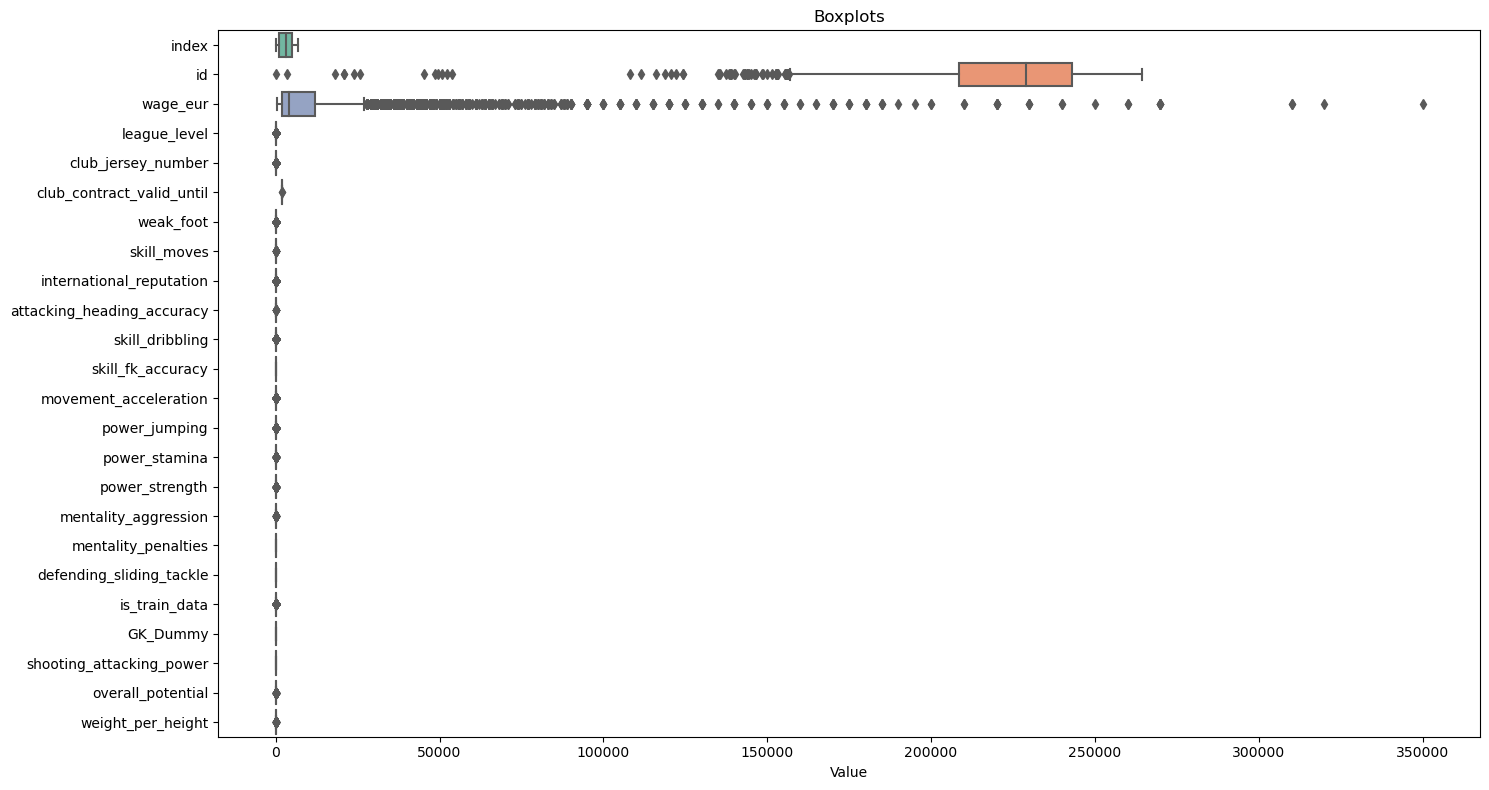

In [52]:
# looking at outliers
numerical_columns = [col for col in df_without_gk.select_dtypes(include='number').columns]
plt.figure(figsize=(15, 8))

sns.boxplot(data=df_without_gk[numerical_columns], orient="h", palette="Set2")
plt.title("Boxplots")
plt.xlabel("Value")

plt.tight_layout()

# Show the plot
plt.show()

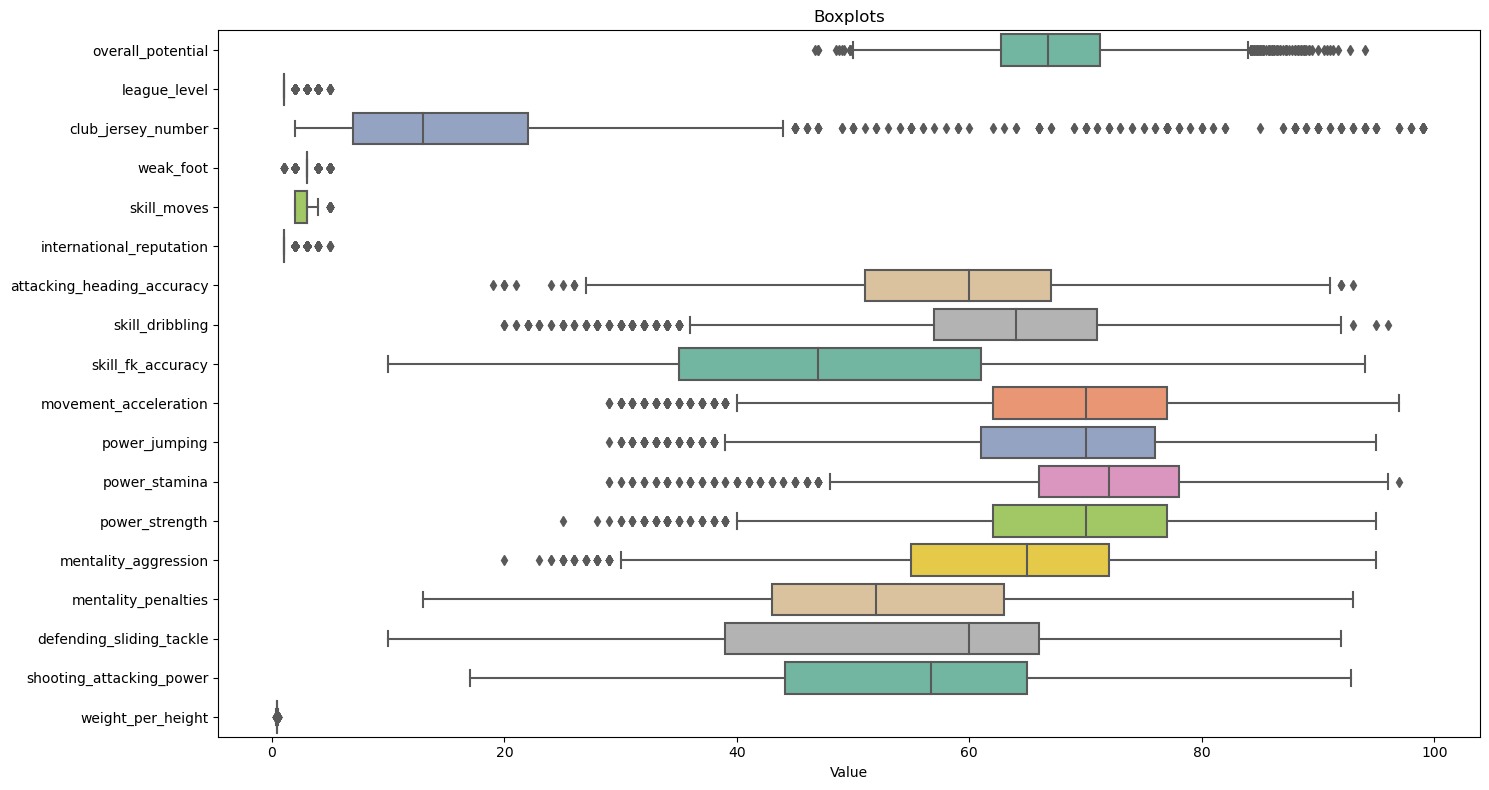

In [53]:
plt.figure(figsize=(15, 8))

sns.boxplot(data=df_without_gk[['overall_potential', 'league_level', 'club_jersey_number', 'weak_foot', 'skill_moves', 'international_reputation', 'attacking_heading_accuracy', 'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_penalties', 'defending_sliding_tackle', 'shooting_attacking_power', 'weight_per_height']], orient="h", palette="Set2")
plt.title("Boxplots")
plt.xlabel("Value")

plt.tight_layout()

# Show the plot
plt.show()


# Taking care of categorical variables

Categorical variables need to be taken in a serious consideration here and they can give us good tips about the position of the player.

We first want to list how many categorical variables we have and how many unique values we have from each one.

This is important to the question what type of treatment we will do for each value.

In [54]:
calculate_column_statistics_for_categorical_variables(df_without_gk)

Total number of columns: 36
Number of categorical columns: 12


Variable  Number of Unique Values  \
0         short_name                     6752   
1      birthday_date                     3959   
2      player_traits                      741   
3          club_name                      701   
4   nationality_name                      144   
5        player_tags                       64   
6        league_name                       55   
7           position                       23   
8          body_type                       10   
9          work_rate                        9   
10    preferred_foot                        2   
11         real_face                        2   

                                                                             Top 5 Most Frequent Values  
0                                             [J. Rodríguez, J. Brown, Danilo, L. Rodríguez, M. Camara]  
1                                          [1992-02-29, 1996-02-29, 2000-02-29, 1988-02-29, 1991-01-08]  
2   [Speed Dribbler (AI), Power Header, Dives Into Tackles (AI), Long Shot Taker (AI), Long Passer (...  
3                          [Vissel Kobe, Raków Częstochowa, F.C. Hansa Rostock, Cracovia, FC St. Pauli]  
4                                                          [England, Brazil, Germany, Spain, Argentina]  
5                                 [#Strength, #Engine, #Acrobat, #Speedster, #Aerial Threat, #Strength]  
6   [USA Major League Soccer, Argentina Primera División, English League Championship, English Leagu...  
7                                                                                [LCB, RCB, RB, LB, ST]  
8                         [Normal (170-185), Lean (170-185), Normal (185+), Lean (185+), Normal (170-)]  
9                                        [Medium/Medium, High/Medium, Medium/High, High/High, High/Low]  
10                                                                                        [Right, Left]  
11                                                                                            [No, Yes]

The categorical variable birthday_date could be interesting regarding the age of the player. We therefore encode it to a numerical variable birth_date.

In [55]:
# Convert 'birthday' to datetime format
df_without_gk['birthday_date'] = pd.to_datetime(df_without_gk['birthday_date'])

# Extract the year and create a new 'year_born' column
df_without_gk['year_born'] = df_without_gk['birthday_date'].dt.year

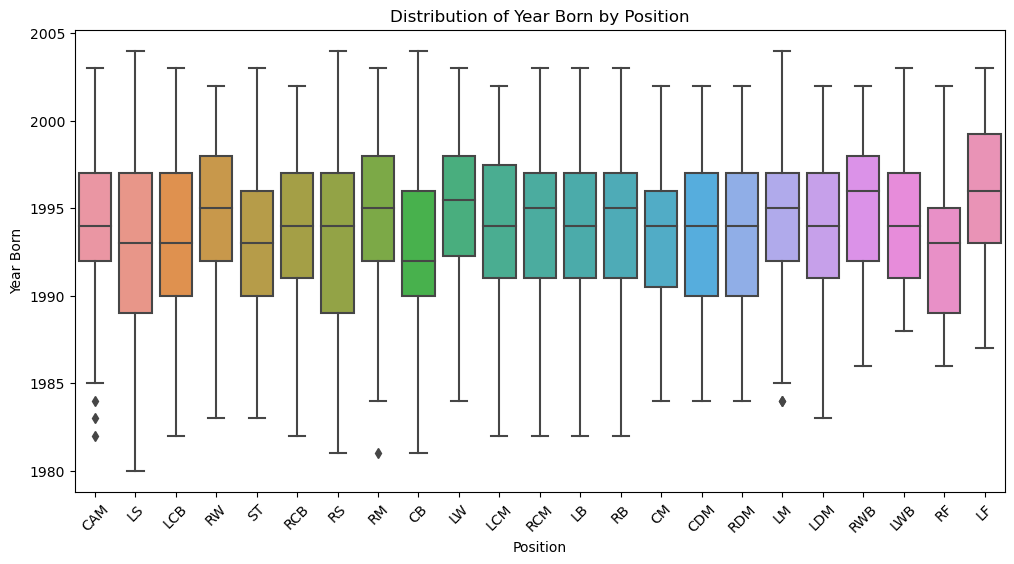

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='position', y='year_born', data=df_without_gk)

plt.title('Distribution of Year Born by Position')
plt.xlabel('Position')
plt.ylabel('Year Born')
plt.xticks(rotation=45) # Rotate the x labels if they are crowded
plt.show()

The distribution of birth years across positions seems relatively consistent, with the medians clustered around the late 1990s. There are no significant visual differences suggesting a strong correlation between the position and the year born, as the median lines are relatively at the same level across positions. However, there are slight variations in the spread and outliers for different positions.

To investigate the influence of categorical variables on player positions, you can apply the Chi-Square Test of Independence. 

Null Hypothesis is that both variables are not correlated.If the p-value is below a significance level (e.g., 0.05), you may reject the null hypothesis, indicating a significant association between the two variables.

Function to check whether categorical variables have impact on position

In [57]:
def chi_square_test(variables):
    for i in variables:
        contingency_table = pd.crosstab(df_without_gk[i], df_without_gk['position'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"Chi-Square Value of {i}: {chi2}")
        print(f"P-value of {i}: {p}")
        if p < 0.05:
            print(f'Because of the low p-value we can reject the null hypothesis. Therefore we can say that {i} has an impact on the position and we should keep the column and encode it.')
        else:
            print(f'The very high p-value means that we cannot reject the null hypothesis and therefore have high evidence that {i} has no effect on position. We therefore drop the column')    
        print()

In [58]:
chi_square_test(df_without_gk[['short_name','player_traits', 'club_name', 'nationality_name', 'player_tags', 'league_name', 'body_type', 'work_rate', 'preferred_foot', 'real_face']])

Chi-Square Value of short_name: 134087.77886574846
P-value of short_name: 0.4005452662420433
The very high p-value means that we cannot reject the null hypothesis and therefore have high evidence that short_name has no effect on position. We therefore drop the column

Chi-Square Value of player_traits: 20208.188545709403
P-value of player_traits: 2.875924981882893e-147
Because of the low p-value we can reject the null hypothesis. Therefore we can say that player_traits has an impact on the position and we should keep the column and encode it.

Chi-Square Value of club_name: 9842.133175374396
P-value of club_name: 1.0
The very high p-value means that we cannot reject the null hypothesis and therefore have high evidence that club_name has no effect on position. We therefore drop the column

Chi-Square Value of nationality_name: 3337.7060466922885
P-value of nationality_name: 0.008709297604703167
Because of the low p-value we can reject the null hypothesis. Therefore we can say that natio

Findings:

Club Joined Date ('club_joined'):
The date a player joined their current club is not a significant predictor of their playing position. This makes sense because a player's tenure at a club is generally unrelated to the specific skills and roles required for different positions on the field.

Player's Short Name ('short_name'):
As expected, a player’s short name has no bearing on their playing position. This is logical because a name is simply an identifier and does not reflect a player's abilities or the position they are suited for in the game.

Club Name ('club_name'):
The club a player is associated with does not significantly impact their playing position. This finding is intuitive as every football club is composed of players covering all positions, so the name of the club does not indicate a player's specific role.

In [59]:
columns_to_drop = ['short_name', 'club_name']

# Drop the specified columns
df_without_gk.drop(columns=columns_to_drop, inplace=True)

As we've observed, we're dealing with two binary variables, which means we can represent them using binary encoding: assigning 1 when one particular value is taken and 0 otherwise.

In [60]:
def encode_binary_categorical_and_drop_originals(df):
    if 'preferred_foot' in df.columns:
        df['preferred_foot'] = df['preferred_foot'].map({'Left': 0, 'Right': 1})
        print("preferred_foot: 'Left' is encoded as 0, 'Right' is encoded as 1")
    
    if 'real_face' in df.columns:
        df['real_face'] = df['real_face'].map({'No': 0, 'Yes': 1})
        print("real_face: 'No' is encoded as 0, 'Yes' is encoded as 1")

    return df
df_without_gk=encode_binary_categorical_and_drop_originals(df_without_gk)

preferred_foot: 'Left' is encoded as 0, 'Right' is encoded as 1
real_face: 'No' is encoded as 0, 'Yes' is encoded as 1


In [61]:
print(df_without_gk.columns)

Index(['index', 'id', 'wage_eur', 'birthday_date', 'league_name',
       'league_level', 'club_jersey_number', 'club_contract_valid_until',
       'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'real_face',
       'player_tags', 'player_traits', 'attacking_heading_accuracy',
       'skill_dribbling', 'skill_fk_accuracy', 'movement_acceleration',
       'power_jumping', 'power_stamina', 'power_strength',
       'mentality_aggression', 'mentality_penalties',
       'defending_sliding_tackle', 'position', 'is_train_data', 'GK_Dummy',
       'shooting_attacking_power', 'overall_potential', 'weight_per_height',
       'year_born'],
      dtype='object')


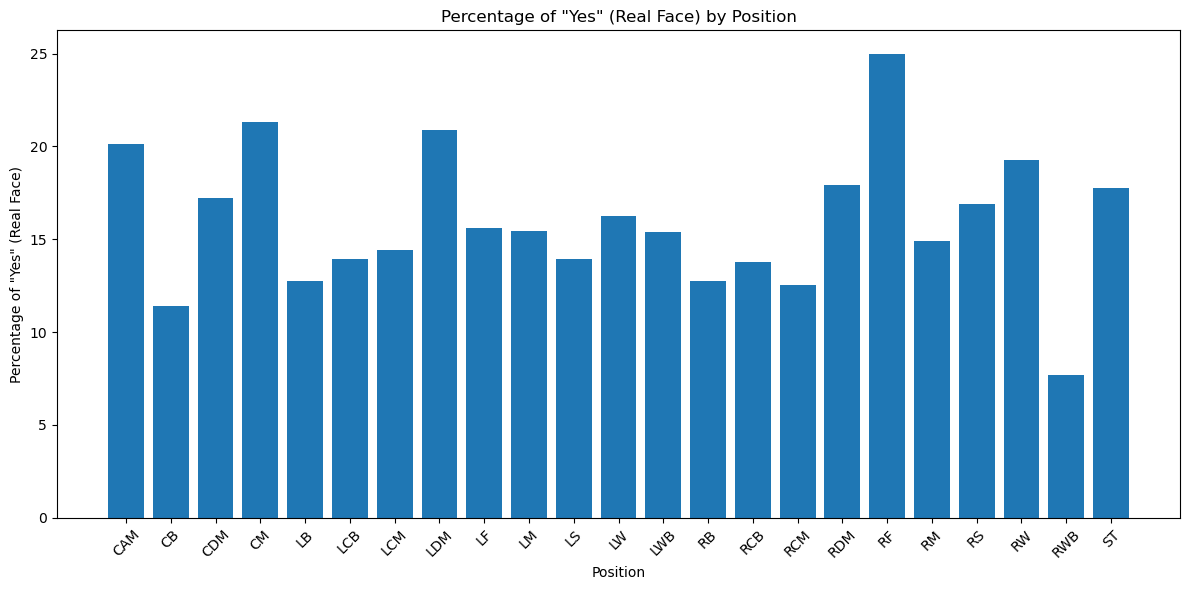

In [62]:
# Group by 'position'
grouped = df_without_gk.groupby('position')

# Calculate the proportion of 'Yes' for each group
proportions = grouped['real_face'].mean() * 100  # Multiply by 100 to get percentages

# Reset the index to make it a DataFrame
proportions_df = proportions.reset_index()

# Rename the column to 'real_face_proportion'
proportions_df = proportions_df.rename(columns={'real_face': 'real_face_proportion'})

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    proportions_df['position'],
    proportions_df['real_face_proportion'],
)

plt.xlabel('Position')
plt.ylabel('Percentage of "Yes" (Real Face)')
plt.title('Percentage of "Yes" (Real Face) by Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There seem to be some position that have a higher degree of real face than another, so this variable may indicate something. The rational behind could be the prominence of the position or the popularity of players in that role.

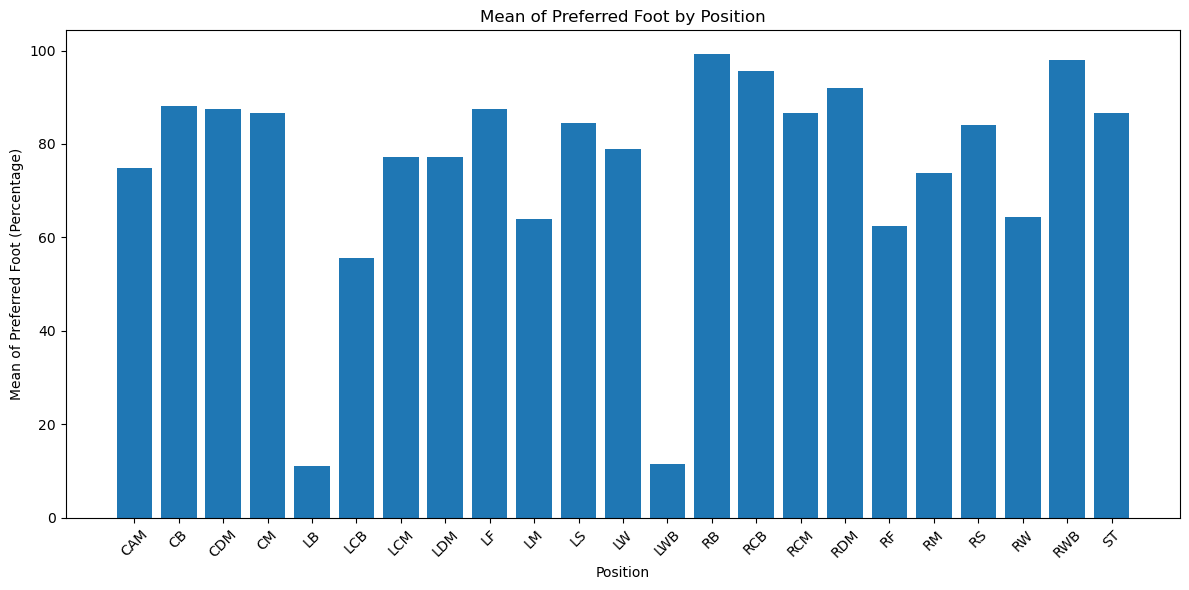

In [63]:

# Group by 'position' and calculate the mean of 'preferred_foot_encoded'
mean_preferred_foot = df_without_gk.groupby('position')['preferred_foot'].mean() * 100  # Multiply by 100 to get percentages

# Reset the index to make it a DataFrame
mean_preferred_foot_df = mean_preferred_foot.reset_index()

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    mean_preferred_foot_df['position'],
    mean_preferred_foot_df['preferred_foot'],
)

plt.xlabel('Position')
plt.ylabel('Mean of Preferred Foot (Percentage)')
plt.title('Mean of Preferred Foot by Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

By examining the graph, it becomes evident that there is diversity among the data, and certain positions show a notable relevance for players with a left prefered foot. This becomes apparent as the mean value approaches 0, indicating fewer instances with a value of 1 and a higher presence of left prefered foot players in those positions.

In essence, this suggests that the preferred foot variable is more likely to influence the player's position compared to the real_face variable.

Now, I am going to encode, nationality name, league name.

In [64]:
def encode_specific_variables_league_nationality(df):
    # Ordinal encoding for 'nationality_name' and 'league_name'
    encoder = OrdinalEncoder()
    df['nationality_name'] = encoder.fit_transform(df[['nationality_name']])
    df['league_name'] = encoder.fit_transform(df[['league_name']])

    return df

# Applying the function to the DataFrame
df_without_gk = encode_specific_variables_league_nationality(df_without_gk)

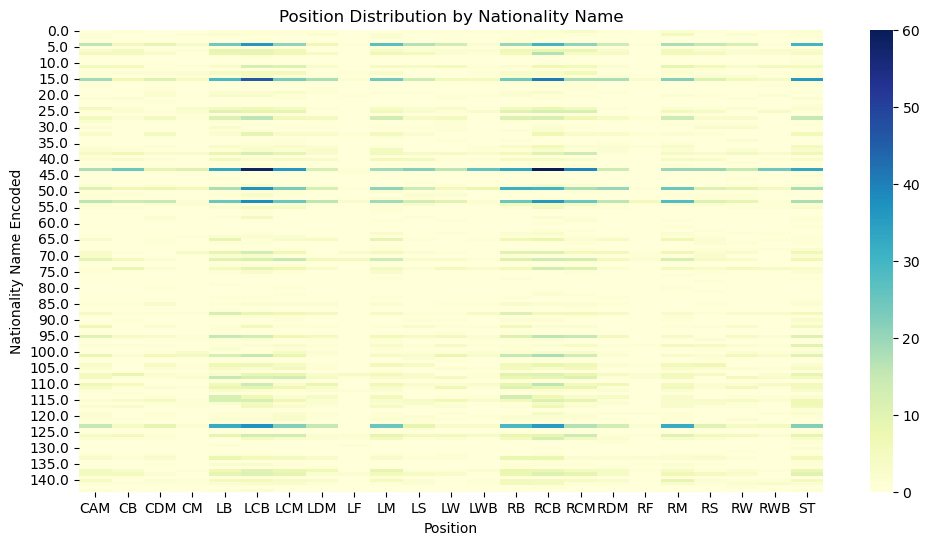

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table to calculate the counts of positions by nationality name
pivot_table = df_without_gk.pivot_table(index='nationality_name', columns='position', aggfunc='size', fill_value=0)

# Create a heatmap for position distribution by nationality name
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False)
plt.title('Position Distribution by Nationality Name')
plt.xlabel('Position')
plt.ylabel('Nationality Name Encoded')
plt.show()

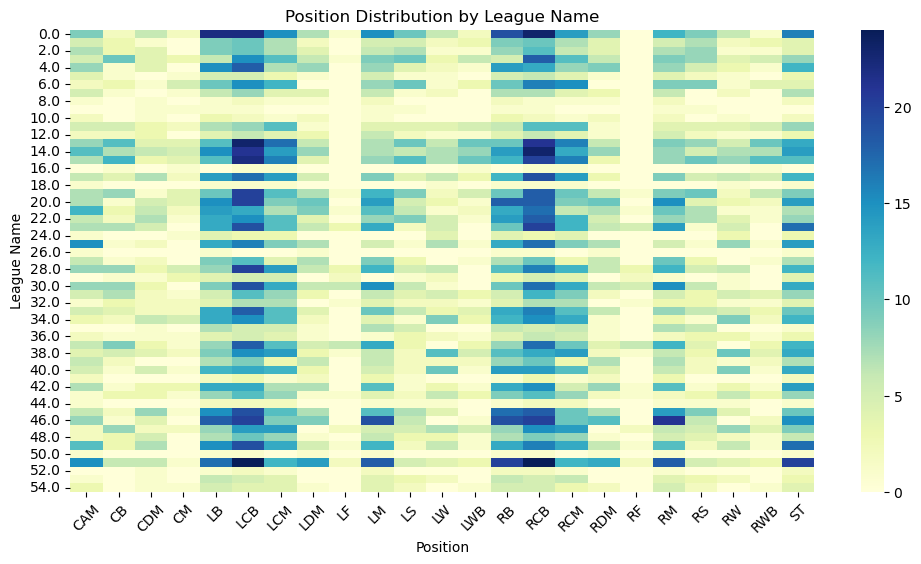

In [66]:
# Create a pivot table to calculate the counts of positions by league name
pivot_table_league = df_without_gk.pivot_table(index='league_name', columns='position', aggfunc='size', fill_value=0)

# Create a heatmap for position distribution by league name
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_league, cmap='YlGnBu', annot=False)
plt.title('Position Distribution by League Name')
plt.xlabel('Position')
plt.ylabel('League Name')
plt.xticks(rotation=45)  # Rotate position labels if necessary
plt.yticks(rotation=0)   # Ensure league names are horizontal for readability
plt.show()

There are a few darker horizontal lines indicating certain nationalities have a higher count of players across various positions. This could imply that these nationalities are more common within the dataset. Additionally, some positions like CM, CB, and ST show a broader range of darker shades across different nationalities, suggesting these positions are more commonly represented across the dataset's nationalities.

Compared to the previous heatmap based on nationalities, this one suggests that the distribution of positions varies more noticeably across different leagues than it does across nationalities. There are pronounced dark patches that indicate certain positions are particularly prevalent in specific leagues. For example, you can see that some leagues (represented by certain numbers on the Y-axis) have a higher concentration of players in central positions like CM and CDM, while others show a spread across more varied positions.

Both heatmaps are useful for identifying potential patterns of player positions within the categories of nationality and league. However, the league-based heatmap seems to display more distinct variations between the different categories, suggesting that the league a player is in may have a more pronounced impact on the distribution of positions compared to the player's nationality. This could be due to various factors such as the tactical preferences of leagues, the training and development focus in different regions, or recruitment strategies of clubs within the leagues.

In [67]:
def one_hot_encode_with_initials_and_group(df):
    # Apply one-hot encoding and keep the original columns
    work_rate_dummies = pd.get_dummies(df['work_rate'], prefix='work_rate')
    body_type_dummies = pd.get_dummies(df['body_type'], prefix='body_type')

    # Generate new column names by taking the initials of the categorical values
    work_rate_dummies.columns = ['work_rate_' + ''.join([word[0] for word in category.split()]) for category in work_rate_dummies.columns]
    body_type_dummies.columns = ['body_type_' + ''.join([word[0] for word in category.split()]) for category in body_type_dummies.columns]

    # Concatenate the new dummy DataFrames with the original DataFrame
    df = pd.concat([df, work_rate_dummies, body_type_dummies], axis=1)
    
    # Create groups for the new one-hot encoded columns
    work_rate_columns = list(work_rate_dummies.columns)
    body_type_columns = list(body_type_dummies.columns)
    
    # Return the updated DataFrame and the column groups
    return df, work_rate_columns, body_type_columns

df_without_gk, work_rate_columns, body_type_columns = one_hot_encode_with_initials_and_group(df_without_gk)


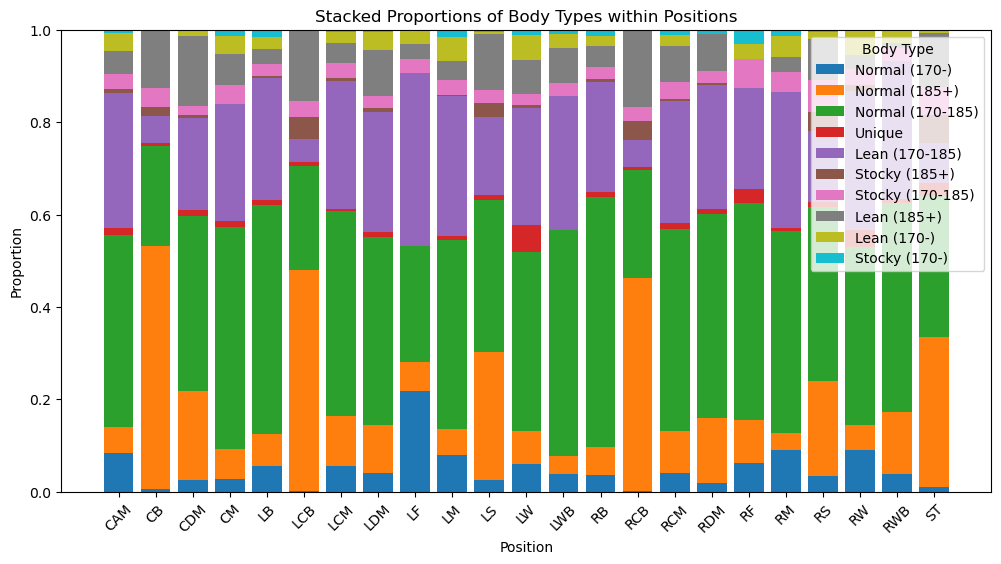

In [68]:


# Assuming you already have body_type_proportions calculated as you mentioned
# body_type_proportions = body_type_counts.divide(body_type_counts.sum(axis=1), axis=0)
# Calculate the count of each work rate within each position
body_type_counts = df_without_gk.groupby('position')['body_type'].value_counts().unstack(fill_value=0)

# Convert counts to proportions
body_type_proportions = body_type_counts.divide(body_type_counts.sum(axis=1), axis=0)
# Get the list of unique body types
unique_body_types = df_without_gk['body_type'].unique()

# Create a dictionary to store data for each body type
data_dict = {body_type: body_type_proportions[body_type] for body_type in unique_body_types}

# Create a stacked bar chart
plt.figure(figsize=(12, 6))
bottom = None  # Variable to keep track of the bottom values for stacking

for body_type in unique_body_types:
    plt.bar(body_type_proportions.index, data_dict[body_type], label=body_type, bottom=bottom)
    if bottom is None:
        bottom = data_dict[body_type]
    else:
        bottom += data_dict[body_type]

# Customize the plot
plt.xlabel('Position')
plt.ylabel('Proportion')
plt.title('Stacked Proportions of Body Types within Positions')
plt.xticks(rotation=45)
plt.legend(title='Body Type', loc='upper right')

# Show the plot
plt.show()


The chart indicates that the "Normal (185+)" body type is prominently represented in the Central Back, Left Central Back, and Right Central Back positions. This suggests that having a taller stature, as implied by the "Normal (185+)" classification, could be an important characteristic for players occupying central defensive roles.

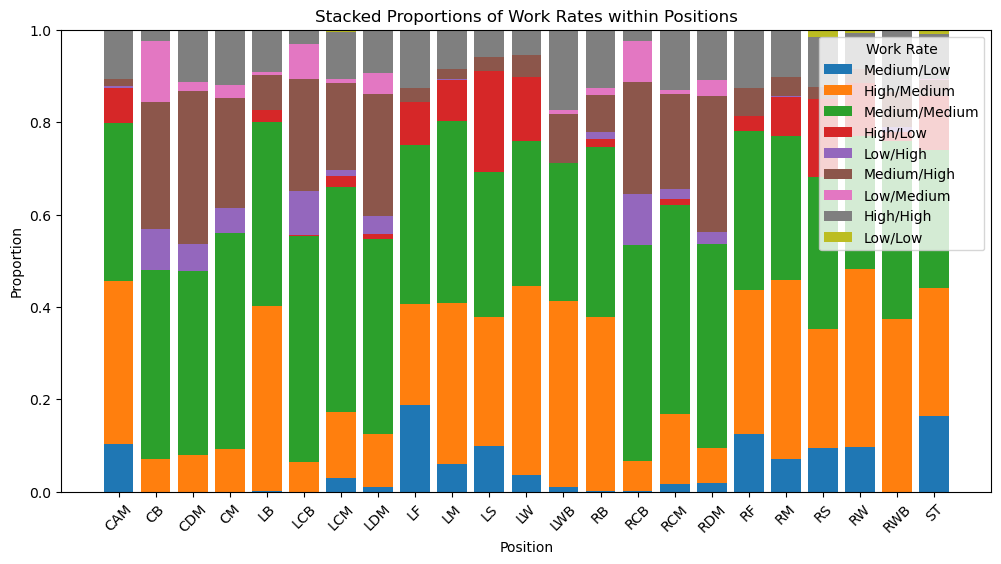

In [69]:

# Calculate the count of each work rate within each position
work_rate_counts = df_without_gk.groupby('position')['work_rate'].value_counts().unstack(fill_value=0)

# Convert counts to proportions
work_rate_proportions = work_rate_counts.divide(work_rate_counts.sum(axis=1), axis=0)

# Get the list of unique work rates
unique_work_rates = df_without_gk['work_rate'].unique()

# Create a dictionary to store data for each work rate
data_dict = {work_rate: work_rate_proportions[work_rate] for work_rate in unique_work_rates}

# Create a stacked bar chart for work rates
plt.figure(figsize=(12, 6))
bottom = None  # Variable to keep track of the bottom values for stacking

for work_rate in unique_work_rates:
    plt.bar(work_rate_proportions.index, data_dict[work_rate], label=work_rate, bottom=bottom)
    if bottom is None:
        bottom = data_dict[work_rate]
    else:
        bottom += data_dict[work_rate]

# Customize the plot
plt.xlabel('Position')
plt.ylabel('Proportion')
plt.title('Stacked Proportions of Work Rates within Positions')
plt.xticks(rotation=45)
plt.legend(title='Work Rate', loc='upper right')

# Show the plot
plt.show()

From these observations, it seems that work rate is an important attribute that varies by position. The prevalence of "High" work rates in more dynamic positions (such as wide players and fullbacks) reflects the physical demands of those roles. Conversely, the presence of "Medium" and "Low" work rates in attacking positions suggests a focus on offensive output over defensive duties.

In [70]:
calculate_column_statistics_for_categorical_variables(df_without_gk)

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [84]:
random_players = df_without_gk.sample(20)[['id', 'player_traits']]
random_players.reset_index(drop=True, inplace=True)
random_players

id  \
0   228290   
1   243640   
2   246070   
3   225106   
4   247641   
5   253303   
6   162240   
7   203263   
8   235002   
9   186157   
10  263152   
11  200812   
12  153244   
13  234202   
14  241379   
15  212449   
16  225853   
17  262353   
18  199131   
19  235056   

                                                                      player_traits  
0                                                                               NaN  
1                                                    Solid Player, Long Passer (AI)  
2                                                             Flair, Playmaker (AI)  
3                                             Solid Player, Dives Into Tackles (AI)  
4                                                           Technical Dribbler (AI)  
5                                                                       Team Player  
6                                     Long Shot Taker (AI), Technical Dribbler (AI)  
7                          Solid Player, Leadership, Long Passer (AI), Power Header  
8                                                                               NaN  
9                 Power Free-Kick, Leadership, Long Shot Taker (AI), Playmaker (AI)  
10                                                                              NaN  
11                                                                    Long Throw-in  
12  Leadership, Finesse Shot, Long Shot Taker (AI), Power Header, Outside Foot Shot  
13                                                       Flair, Speed Dribbler (AI)  
14                                    Long Shot Taker (AI), Technical Dribbler (AI)  
15                                                                     Power Header  
16                                                                     Power Header  
17                                                                              NaN  
18                             Long Throw-in, Solid Player, Technical Dribbler (AI)  
19                                                          Technical Dribbler (AI)

In [85]:
# Repeating the provided steps for df_without_gk
split_traits_without_gk = df_without_gk['player_traits'].dropna().str.split(', ')
unique_traits_without_gk = set(trait for traits in split_traits_without_gk for trait in traits)

# Adding new columns for each trait in df_without_gk
for trait in unique_traits_without_gk:
    df_without_gk[trait] = df_without_gk['player_traits'].apply(lambda x: 1 if pd.notna(x) and trait in x else 0)

# Number of new columns created
num_new_columns = len(unique_traits_without_gk)

# Creating a list of new columns
new_columns_list = list(unique_traits_without_gk)

print("Number of new player trait columns created:", num_new_columns)



Number of new player trait columns created: 20


In [86]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Function to perform chi-squared test and calculate Cramér's V
def chi_squared_test(df, trait, position_col):
    contingency_table = pd.crosstab(df[trait], df[position_col])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()  # Total number of observations
    min_dim = min(contingency_table.shape) - 1  # Minimum of the number of categories in rows or columns
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    return cramers_v

# Applying the function to each trait and sorting the results
cramers_v_results = {trait: chi_squared_test(df_without_gk, trait, 'position') for trait in new_columns_list}
sorted_cramers_v = sorted(cramers_v_results.items(), key=lambda x: x[1], reverse=True)

# Displaying the sorted results
sorted_cramers_v

[('Technical Dribbler (AI)', 0.37609208380245973),
 ('Speed Dribbler (AI)', 0.35439618768279435),
 ('Flair', 0.3282039343180367),
 ('Playmaker (AI)', 0.3185732169294576),
 ('Power Header', 0.2891718887841292),
 ('Early Crosser', 0.2801266412758477),
 ('Finesse Shot', 0.25588205884584714),
 ('Long Shot Taker (AI)', 0.2523512128564063),
 ('Long Passer (AI)', 0.23394388504987726),
 ('Outside Foot Shot', 0.22149280705044191),
 ('Dives Into Tackles (AI)', 0.19998312928683956),
 ('Long Throw-in', 0.1904442252810476),
 ('Leadership', 0.17184321133494726),
 ('Chip Shot (AI)', 0.15794639163763444),
 ('Team Player', 0.11376187346032797),
 ('Solid Player', 0.08960984333830938),
 ('Injury Prone', 0.07816067013843421),
 ('Power Free-Kick', 0.07769313257494989),
 ('One Club Player', 0.07658583648115874),
 ('Giant Throw-in', 0.07137353717452202)]

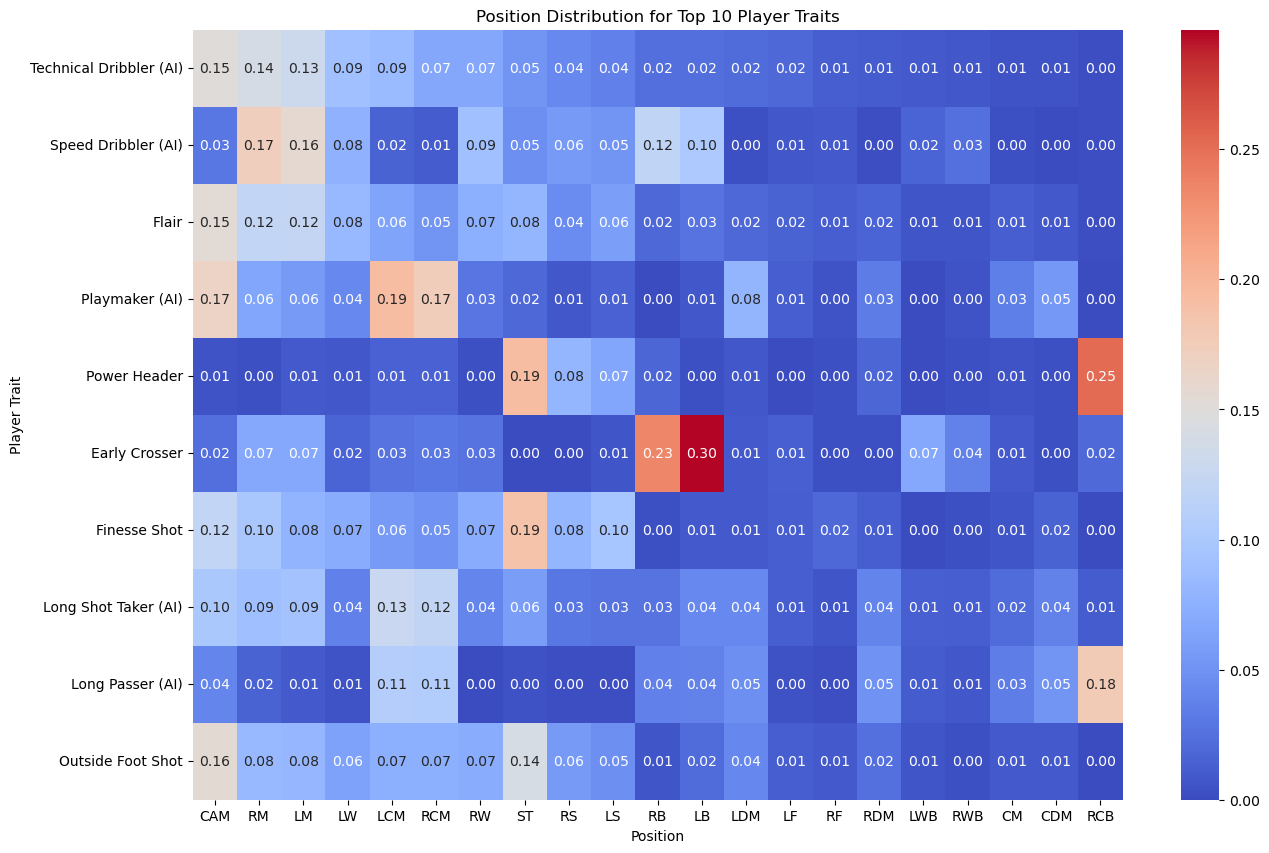

In [101]:
# Selecting the top ten traits based on Cramér's V values for detailed analysis
top_ten_traits = sorted_cramers_v[:10]

# Creating a DataFrame to store position frequencies for each of these traits
top_ten_analysis = pd.DataFrame()

# Iterating over the top ten traits to calculate position frequencies
for trait, _ in top_ten_traits:
    # Creating a sub-dataframe where the trait is present
    sub_df = df_without_gk[df_without_gk[trait] == 1]
    
    # Counting the frequency of each position in this subset
    position_counts = sub_df['position'].value_counts(normalize=True)
    
    # Adding this data to our analysis DataFrame
    top_ten_analysis[trait] = position_counts

# Transposing for better visualization format
top_ten_analysis = top_ten_analysis.T.fillna(0)

# Plotting the data
plt.figure(figsize=(15, 10))
sns.heatmap(top_ten_analysis, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Position Distribution for Top 10 Player Traits')
plt.xlabel('Position')
plt.ylabel('Player Trait')
plt.show()

In [98]:
# Repeating the provided steps for the 'player_tags' column in df_without_gk
split_tags_without_gk = df_without_gk['player_tags'].dropna().str.split(', ')
unique_tags_without_gk = set(tag for tags in split_tags_without_gk for tag in tags)

# Adding new columns for each tag in df_without_gk
for tag in unique_tags_without_gk:
    df_without_gk[tag] = df_without_gk['player_tags'].apply(lambda x: 1 if pd.notna(x) and tag in x else 0)

# Number of new columns created for tags
num_new_columns_tags = len(unique_tags_without_gk)

# Creating a list of new columns for tags
new_columns_list_tags = list(unique_tags_without_gk)

num_new_columns_tags, new_columns_list_tags



(20,
 ['#Tactician\xa0',
  '#Playmaker\xa0',
  '#Aerial Threat',
  '#Dribbler',
  '#Tackling\xa0',
  '#Poacher',
  '#Complete Defender',
  '#Acrobat',
  '#Complete Forward',
  '#Tactician',
  '#Tackling',
  '#FK Specialist',
  '#Crosser',
  '#Strength',
  '#Complete Midfielder',
  '#Playmaker',
  '#Clinical Finisher',
  '#Speedster',
  '#Engine',
  '#Distance Shooter'])

In [105]:
cramers_v_results = {tag: chi_squared_test(df_without_gk, tag, 'position') for tag in new_columns_list_tags}
sorted_cramers_v_tags = sorted(cramers_v_results.items(), key=lambda x: x[1], reverse=True)

# Displaying the sorted results
sorted_cramers_v_tags

[('#Strength', 0.25665056891481813),
 ('#Acrobat', 0.20491042869697754),
 ('#Speedster', 0.1957157222778326),
 ('#Dribbler', 0.13478356720271625),
 ('#Engine', 0.12859683830374138),
 ('#Aerial Threat', 0.12435574762097663),
 ('#Clinical Finisher', 0.12064116121902378),
 ('#Playmaker', 0.1066888899278895),
 ('#Complete Forward', 0.10604618744020648),
 ('#Playmaker\xa0', 0.09264535414782599),
 ('#Tactician', 0.09056375194451677),
 ('#Complete Midfielder', 0.08879344696638228),
 ('#Poacher', 0.08598486187601204),
 ('#Tactician\xa0', 0.08387856274793663),
 ('#FK Specialist', 0.08260921054194073),
 ('#Distance Shooter', 0.0818744284378338),
 ('#Tackling', 0.07666720409329537),
 ('#Crosser', 0.062130061762685394),
 ('#Complete Defender', 0.06199570250028807),
 ('#Tackling\xa0', 0.050735145131517646)]

In [109]:
# Selecting the top ten traits based on Cramér's V values for detailed analysis
top_ten_tags = sorted_cramers_v_tags[:10]

# Creating a DataFrame to store position frequencies for each of these traits
top_ten_analysis_tags = pd.DataFrame()

# Iterating over the top ten traits to calculate position frequencies
for tag, _ in top_ten_tags:
    # Creating a sub-dataframe where the trait is present
    sub_df = df_without_gk[df_without_gk[tag] == 1]
    
    # Counting the frequency of each position in this subset
    tag_counts = sub_df['position'].value_counts(normalize=True)
    
    # Adding this data to our analysis DataFrame
    top_ten_analysis[tag] = tag_counts

# Transposing for better visualization format
top_ten_analysis_tags = top_ten_analysis_tags.T.fillna(0)

# Plotting the data
plt.figure(figsize=(15, 10))
sns.heatmap(top_ten_analysis_tags, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Position Distribution for Top 10 Player Tags')
plt.xlabel('Position')
plt.ylabel('Player Tag')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1500x1000 with 0 Axes>

Done, lets go to test

# Final Check up before testing

In [93]:
calculate_column_statistics_for_categorical_variables(df_without_gk)

index                         int64
id                            int64
short_name                   object
overall                       int64
potential                     int64
                              ...  
defending_standing_tackle     int64
defending_sliding_tackle      int64
position                     object
train_dummy                   int64
GK_Dummy                      int64
Length: 67, dtype: object


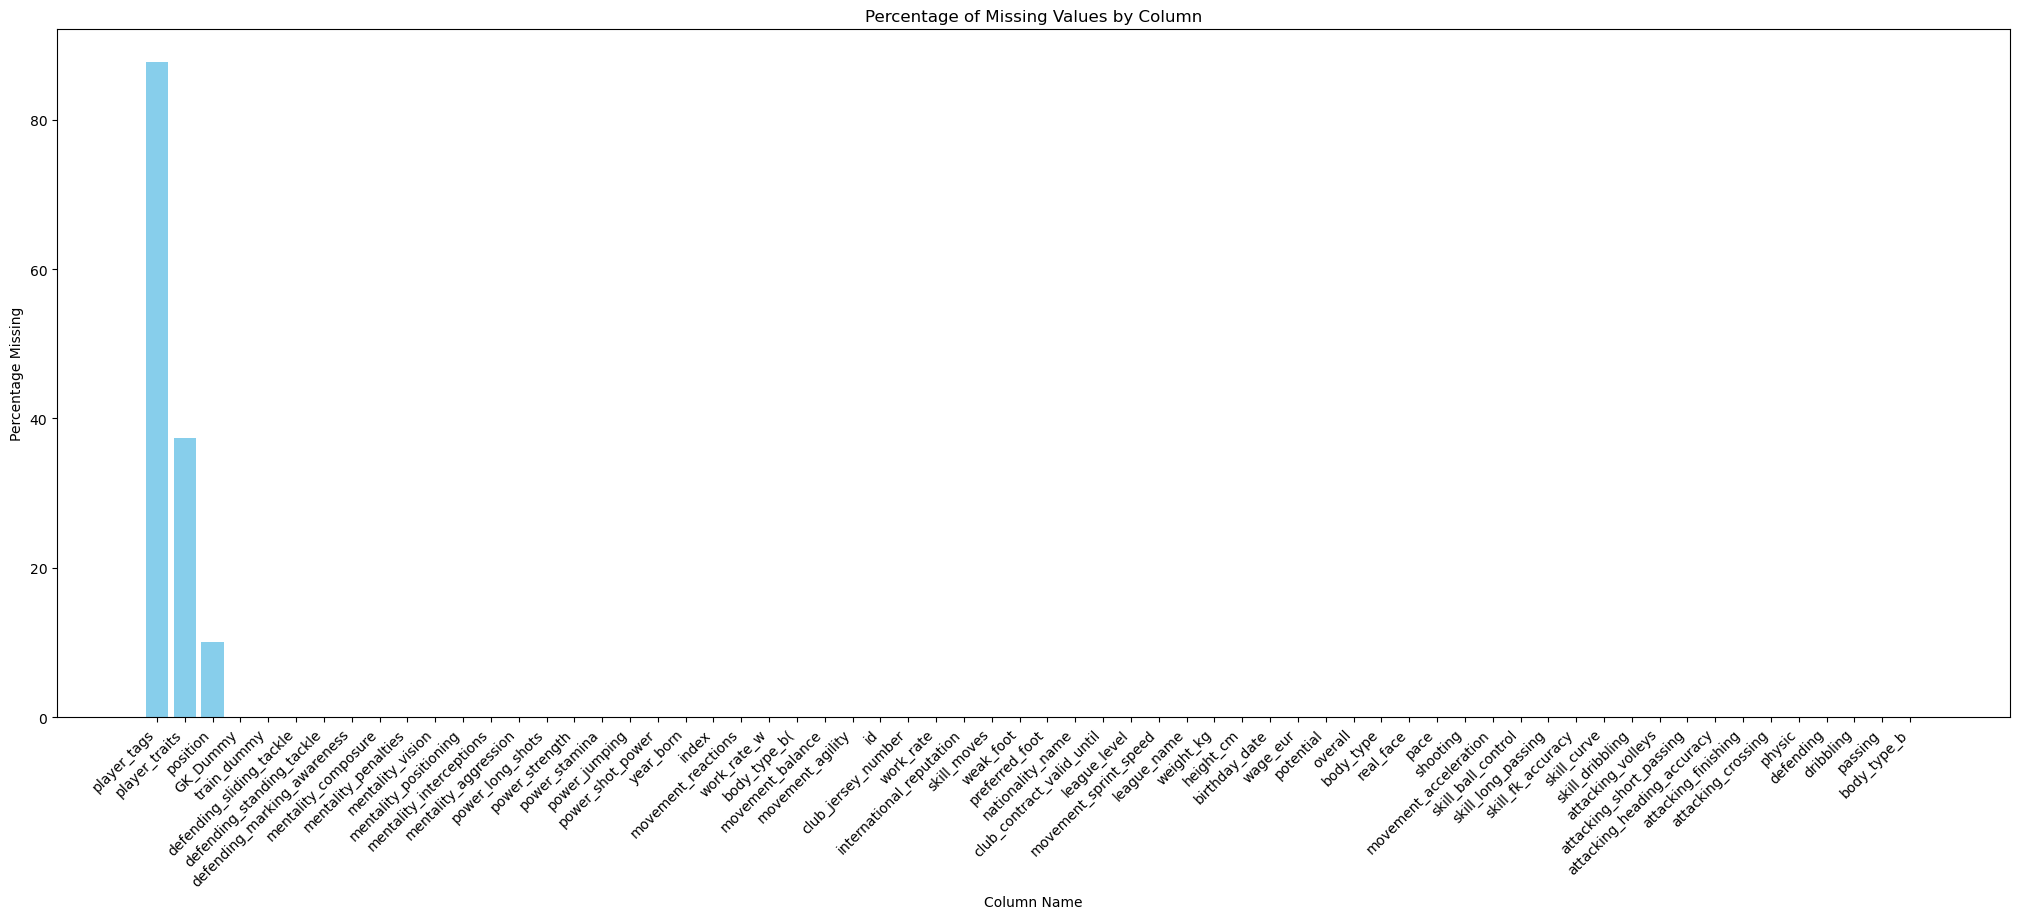


Columns with Missing Values (Descending Order):
player_tags: 87.7% (Categorical)
player_traits: 37.37% (Categorical)
position: 10.01% (Categorical)


In [87]:
calculate_missing_info_print_only(df_without_gk)


don't know yet how to deal with player_tags and player_traits..... Ignore them first

In [58]:
def list_numerical_columns_horizontally_with_quotes(df):
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_columns_with_quotes = ', '.join([f'"{col}"' for col in numerical_columns])
    return numerical_columns_with_quotes

list_numerical_columns_horizontally_with_quotes(df_without_gk)

'"index", "id", "wage_eur", "league_level", "club_jersey_number", "club_contract_valid_until", "preferred_foot", "weak_foot", "skill_moves", "international_reputation", "real_face", "attacking_heading_accuracy", "skill_dribbling", "skill_fk_accuracy", "movement_acceleration", "power_jumping", "power_stamina", "power_strength", "mentality_aggression", "mentality_penalties", "defending_sliding_tackle", "is_train_data", "shooting_attacking_power", "overall_potential", "weight_per_height"'

### Separating the dfs for training and testing

In [59]:
"""From the numerical I will drop id, club_jersey_number and club_contract_valid_until"""
# Seperating test and train
X_train = df_without_gk[df_without_gk['is_train_data'] == 1][["wage_eur", "league_level", "club_jersey_number", "club_contract_valid_until", "preferred_foot", "weak_foot", "skill_moves", "international_reputation", "real_face", "attacking_heading_accuracy", "skill_dribbling", "skill_fk_accuracy", "movement_acceleration", "power_jumping", "power_stamina", "power_strength", "mentality_aggression", "mentality_penalties", "defending_sliding_tackle",  "shooting_attacking_power", "overall_potential", "weight_per_height"]]
y_train = df_without_gk[df_without_gk['is_train_data'] == 1][['position']]

X_test = df_without_gk[df_without_gk['is_train_data'] == 0][["wage_eur", "league_level", "club_jersey_number", "club_contract_valid_until", "preferred_foot", "weak_foot", "skill_moves", "international_reputation", "real_face", "attacking_heading_accuracy", "skill_dribbling", "skill_fk_accuracy", "movement_acceleration", "power_jumping", "power_stamina", "power_strength", "mentality_aggression", "mentality_penalties", "defending_sliding_tackle",  "shooting_attacking_power", "overall_potential", "weight_per_height"]]

# **Classification - Prediction**

In [270]:
# Training the Random Forest Classifier
model = RandomForestClassifier(random_state=123)
model.fit(X_train, y_train)

# Making predictions for test_dataset
y_test_predicted = model.predict(X_test)

# Filling in the missing 'position' values in test_dataset
pred_df = pd.DataFrame()
pred_df['id'] = df_without_gk[df_without_gk['is_train_data'] == 0]['id']
pred_df['pred'] = y_test_predicted



In [370]:
###TESTING THE Gradient boosting classifier to verify the score on kaggle###

#Gb = GradientBoostingClassifier(random_state=123, n_estimators=100, learning_rate=0.1, max_depth=3, max_features='sqrt')
# Training the Random Forest Classifier
model = GradientBoostingClassifier(random_state=123, n_estimators=110, learning_rate=0.1, max_depth=3, max_features='sqrt')    #n_estimators = number of trees

model.fit(X_train, y_train)

# Making predictions for test_dataset
y_test_predicted = model.predict(X_test)

# Filling in the missing 'position' values in test_dataset
pred_df = pd.DataFrame()
pred_df['id'] = df_without_gk[df_without_gk['is_train_data'] == 0]['id']
pred_df['pred'] = y_test_predicted

# Cross Validation

### Cross Validation for **Random Forest**

Find the best hyperparameter (around 30 mins to run)

In [302]:
Rf = RandomForestClassifier(random_state=123)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],   # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at leaf nodes
    'max_features': ['sqrt', 'log2']  # Number of features to consider for split
}

# Perform GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=Rf, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Latest F1 score:

KeyboardInterrupt: 

In [60]:
# Creating the Random Forest Classifier model
Rf = RandomForestClassifier(random_state=123, n_estimators=110, max_depth= None ,min_samples_split=10, min_samples_leaf=4 ,max_features='sqrt', bootstrap=True)

# Calculating the accuracy, precision, recall, and F1-score for each fold
#Rf_accuracy_scores = cross_val_score(Rf, X_train, y_train, cv=5, scoring='accuracy')
#Rf_precision_scores = cross_val_score(Rf, X_train, y_train, cv=5, scoring='precision_macro')
#Rf_recall_scores = cross_val_score(Rf, X_train, y_train, cv=5, scoring='recall_macro')
Rf_f1_scores = cross_val_score(Rf, X_train, y_train, cv=5, scoring='f1_macro')

# Printing the mean and standard deviation of each metric
#print("Mean accuracy score:", Rf_accuracy_scores.mean())
#print("Mean precision score:", Rf_precision_scores.mean())
#print("Mean recall score:", Rf_recall_scores.mean())
print("Mean F1 score:", Rf_f1_scores.mean())
#print("Standard deviation of F1 score:", Rf_f1_scores.std())



Mean F1 score: 0.17927048955997002


### Cross Validation for **Gradient Boosting Classifier**

Find the best hyperparameter for GBC (around 4 hours to run)

In [311]:
gb = GradientBoostingClassifier(random_state=123)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],   # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at leaf nodes
    'max_features': ['sqrt', 'log2']  # Number of features to consider for split
}

# Perform GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)



KeyboardInterrupt: 

In [61]:
# Creating the Gradient Boosting Classifier model
Gb = GradientBoostingClassifier(random_state=123, n_estimators=110, learning_rate=0.1, max_depth=3, max_features='sqrt')    #n_estimators = number of trees
    #learning_rate = how much each tree is allowed to correct the mistakes of the previous trees
    #max_depth = how many splits each tree is allowed to make
    
# Calculating the accuracy, precision, recall, and F1-score for each fold
#Gb_accuracy_scores = cross_val_score(Gb, X_train, y_train, cv=5, scoring='accuracy')
#Gb_precision_scores = cross_val_score(Gb, X_train, y_train, cv=5, scoring='precision_macro')
#Gb_recall_scores = cross_val_score(Gb, X_train, y_train, cv=5, scoring='recall_macro')
Gb_f1_scores = cross_val_score(Gb, X_train, y_train, cv=5, scoring='f1_macro')

# Printing the mean and standard deviation of each metric
#print("Mean accuracy score:", Gb_accuracy_scores.mean())
#print("Mean precision score:", Gb_precision_scores.mean())
#print("Mean recall score:", Gb_recall_scores.mean())
print("Mean F1 score:", Gb_f1_scores.mean())
#print("Standard deviation of F1 score:", Gb_f1_scores.std())

# Latest F1 score: 0.21756532303012385

Mean F1 score: 0.20353864513126302


### Cross Validation for **Logistic Regression**

In [303]:
# Creating the Logistic Regression model
Lr = LogisticRegression(random_state=123)

# Calculating the accuracy, precision, recall, and F1-score for each fold
#Lr_accuracy_scores = cross_val_score(Lr, X_train, y_train, cv=5, scoring='accuracy')
#Lr_precision_scores = cross_val_score(Lr, X_train, y_train, cv=5, scoring='precision_macro')
#Lr_recall_scores = cross_val_score(Lr, X_train, y_train, cv=5, scoring='recall_macro')
Lr_f1_scores = cross_val_score(Lr, X_train, y_train, cv=5, scoring='f1_macro')

# Printing the mean and standard deviation of each metric
#print("Mean accuracy score:", Lr_accuracy_scores.mean())
#print("Mean precision score:", Lr_precision_scores.mean())
#print("Mean recall score:", Lr_recall_scores.mean())
print("Mean F1 score:", Lr_f1_scores.mean())
#print("Standard deviation of F1 score:", Lr_f1_scores.std())

Mean F1 score: 0.05482816337246903


### Cross Validation for **Decision Tree Classifier**

Find the best hyperparameter for GBC (around 4 hours to run)

In [308]:
gb = DecisionTreeClassifier(random_state=123)

# Define the grid of hyperparameters to search
param_grid = {
    'criterion': ['gini', 'entropy'],      # Splitting criterion
    'max_depth': [None, 5, 10, 15],        # Maximum depth of trees
    'min_samples_split': [2, 5, 10, 15],   # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4, 6],      # Minimum samples required at leaf nodes
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider for split
    'splitter': ['best', 'random']         # Strategy to choose the split at each node
}

# Perform GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 15, 'splitter': 'best'}


In [310]:
# Creating the Decision Tree model
Dt = DecisionTreeClassifier(random_state=123, criterion = "entropy", max_depth=None, min_samples_split=15, min_samples_leaf=4, max_features=None, splitter='best')
    # max_depth = hyperparameter that defines the maximum depth of the decision tree. (maximum number of levels that the tree can grow to during training.)
    # min_samples_split = hyperparameter that sets the minimum number of samples required to split an internal node. (node will only be split further if it contains at least 2 samples.)

# Calculating the accuracy, precision, recall, and F1-score for each fold
#Dt_accuracy_scores = cross_val_score(Dt, X_train, y_train, cv=5, scoring='accuracy')
#Dt_precision_scores = cross_val_score(Dt, X_train, y_train, cv=5, scoring='precision_macro')
#Dt_recall_scores = cross_val_score(Dt, X_train, y_train, cv=5, scoring='recall_macro')
Dt_f1_scores = cross_val_score(Dt, X_train, y_train, cv=5, scoring='f1_macro')

# Printing the mean and standard deviation of each metric
#print("Mean accuracy score:", Lr_accuracy_scores.mean())
#print("Mean precision score:", Lr_precision_scores.mean())
#print("Mean recall score:", Lr_recall_scores.mean())
print("Mean F1 score:", Dt_f1_scores.mean())
#print("Standard deviation of F1 score:", Lr_f1_scores.std())

#Latest F1 score: 0.19965866994086084

Mean F1 score: 0.19635100461126537


In [371]:
pred_df


id pred
26    115909  CAM
35    135537  RCB
44    140222  RCB
47    142499  RCM
59    145014  LDM
...      ...  ...
7620  263288   LM
7621  263291   RB
7635  263550  LCB
7645  263808   LM
7646  263823  RCM

[697 rows x 2 columns]

Now we have the predictions for the non-goalkeepers. So, we have to add the ids of the goalkeepers with the prediction 'GK'

In [372]:
merged_df = pd.merge(pred_df, df_test, on='id', how='outer')

In [373]:
merged_df['pred'] = merged_df['pred'].fillna('GK')

In [374]:
merged_df

id pred    short_name  overall  potential  value_eur  wage_eur  \
0    115909  CAM  Rubén Castro       69         69        NaN      3000   
1    135537  RCB      G. Tamaș       67         67     180000      2000   
2    140222  RCB   P. Da Silva       67         67        NaN       500   
3    142499  RCM    Aitor Sanz       70         70     325000      4000   
4    145014  LDM        Juande       67         67     350000      2000   
..      ...  ...           ...      ...        ...        ...       ...   
762  233154   GK     S. Takagi       66         66     425000      1000   
763  210257   GK       Ederson       89         91   94000000    200000   
764  208719   GK       P. Kühn       70         70    1100000      3000   
765  223175   GK      O. Kocuk       69         72    1400000     16000   
766  213729   GK   S. Rossbach       70         76    2000000      2000   

    birthday_date  height_cm  weight_kg  ... defending_marking_awareness  \
0      1981-06-27        169         68  ...                          36   
1      1983-11-09        188         85  ...                          68   
2      1980-02-01        180         76  ...                          70   
3      1984-09-13        181         71  ...                          69   
4      1986-08-12        185         74  ...                          65   
..            ...        ...        ...  ...                         ...   
762    1989-05-22        181         76  ...                          10   
763    1993-08-17        188         86  ...                          29   
764    1992-09-02        188         95  ...                           8   
765    1995-07-27        188         78  ...                           5   
766    1996-02-07        189         80  ...                          16   

    defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                          12                        14                  14   
1                          66                        65                  12   
2                          67                        64                   9   
3                          64                        60                  14   
4                          64                        62                  13   
..                        ...                       ...                 ...   
762                        10                        12                  64   
763                        15                         8                  87   
764                        17                        16                  70   
765                        10                        11                  71   
766                        18                        17                  71   

    goalkeeping_handling goalkeeping_kicking  goalkeeping_positioning  \
0                      8                  15                        8   
1                      8                  13                        7   
2                      8                  15                       16   
3                     11                  12                        9   
4                      5                  12                       12   
..                   ...                 ...                      ...   
762                   65                  70                       66   
763                   82                  93                       88   
764                   63                  69                       72   
765                   68                  62                       64   
766                   66                  66                       67   

    goalkeeping_reflexes  goalkeeping_speed train_dummy  
0                     12                NaN           0  
1                      7                NaN           0  
2                      9                NaN           0  
3                     16                NaN           0  
4                     14                NaN           0  
..                   

In [375]:
selected_columns = ['id', 'pred']
new_test_dataset = merged_df[selected_columns]

#export_data_path = 'C:/Users/vanes/Desktop/BSE/Term 1/Computational Machine Learning/Project_2/try_Vanessa.csv'
export_data_path = '/Users/mathieu26/Desktop/DSDM-BSE/Term 1/Computational Machine Learning/Project2/ML2_Les_Corts-1/Prediction.csv'
new_test_dataset.to_csv(export_data_path, index=False)

